In [1]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core, penalty_matrix, make_input_matrices, make_input_matrices_forces
from statmechlib.forcefields import f_embed, f_dens, f_spline3, energy
from statmechlib.forcefields import loss_energy_penalized, jacobian_energy_penalized
from statmechlib.forcefields import loss_sd2_penalized, jacobian_sd2_penalized
from statmechlib.forcefields import loss_sd2f_penalized

In [4]:
working = '../data/working'

In [5]:
# params_file = 'marinica_params'
# with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
#     param_list = pickle.load(fi)  

In [6]:
params_file = 'marinica_bs'
with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)

In [7]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)

In [8]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [9]:
stats_file = 'stats_bs_force_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi, encoding='latin1')

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_force_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi, encoding='latin1')

len 50


In [10]:
targets['eos']['box'] = targets['eos']['box'][0:1]
targets['eos']['xyz'] = targets['eos']['xyz'][0:1]
targets['eos']['temp'] = targets['eos']['temp'][0:1]
targets['eos']['beta'] = targets['eos']['beta'][0:1]
targets['eos']['energy'] = targets['eos']['energy'][0:1]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][0:1]
stats_bspline['eos']['forces'] = stats_bspline['eos']['forces'][0:1]

In [11]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]
stats_bspline['eos_bcc']['forces'] = stats_bspline['eos_bcc']['forces'][1:4]

In [12]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]
stats_bspline['relax']['forces'][1] = stats_bspline['inf']['forces'][0]

In [13]:
edens_knots = list(np.linspace(1.05, 4.55, 36))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [14]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [16]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.0 #0.1
targets['eos']['weight'] = 0.0 #1e-4
targets['eos_bcc']['weight'] = 0.0 #0.1
targets['relax']['weight'] = 10.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 0.0
targets['bcc_npt_langevin_300K']['weight'] = 5.0
targets['bcc_npt_langevin_3700K']['weight'] = 3.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

targets['eos']['temp'][0] = 10000.0
targets['eos']['energy'][0] = 20000.0
#targets['eos']['energy']

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 3.0),
 ('liq_5000K', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 10.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 5.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 0.0),
 ('fcc_npt_langevin_300K', 0.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('inf', 0.0),
 ('liq_3700K', 1.0),
 ('eos_bcc', 0.0),
 ('bain', 0.0)]

In [17]:
dl_dict = {key:0.0 for key in tkeys}
# dl_dict['relax'] = 0.03
#dl_dict['bcc_npt_langevin_300K'] = 0.1
# dl_dict['bcc_npt_langevin_3700K'] = 0.03
# dl_dict['vac_npt_langevin_2000K'] = 0.03
# dl_dict['screw_111_npt_langevin_2000K'] = 0.03
# dl_dict['i111_npt_langevin_2000K'] = 0.03
# dl_dict['i110_npt_langevin_2000K'] = 0.01
#dl_dict['liq_3700K'] = 0.01
#dl_dict['eos_bcc'] = 0.1
#dl_dict['bain'] = 0.1
dl_list = [dl_dict[key] for key in tkeys]

In [18]:
[(k,d) for k, d in zip(dl_list, tkeys)]

[(0.0, 'bcc_npt_langevin_300K'),
 (0.0, 'bcc_npt_langevin_3700K'),
 (0.0, 'fcc_npt_langevin_300K'),
 (0.0, 'vac_npt_langevin_2000K'),
 (0.0, 'i110_npt_langevin_2000K'),
 (0.0, 'i111_npt_langevin_2000K'),
 (0.0, 'screw_111_npt_langevin_2000K'),
 (0.0, 'liq_3700K'),
 (0.0, 'liq_5000K'),
 (0.0, 'eos'),
 (0.0, 'eos_bcc'),
 (0.0, 'eos_fcc'),
 (0.0, 'vacint'),
 (0.0, 'bain'),
 (0.0, 'relax')]

## SD matching

**Parameters optimized only on energetics**

In [42]:
b_init = np.array([-1.77236945e-05,  4.82923750e+03,  4.22066944e+03,  3.65746164e+03,
        3.13964314e+03,  2.66710984e+03,  2.23960432e+03,  1.85663747e+03,
        1.51734030e+03,  1.22048619e+03,  9.64385734e+02,  7.46855155e+02,
        5.65250119e+02,  4.16686790e+02,  2.98530275e+02,  2.08598096e+02,
        1.43436584e+02,  9.77225071e+01,  6.77334783e+01,  4.98964693e+01,
        4.04640480e+01,  3.68202368e+01,  3.66445646e+01,  3.78780939e+01,
        3.92254100e+01,  4.00633191e+01,  3.98164560e+01,  3.81964789e+01,
        3.53574057e+01,  3.10575775e+01,  2.55451101e+01,  1.91626397e+01,
        1.25152874e+01,  7.03408097e+00,  2.98947809e+00,  7.80805866e-01,
        8.43725527e-01,  2.46224801e+00,  3.65344444e+00,  2.95514255e+00,
        1.94656632e+00, -1.36276462e+00, 0.0, -1.32595598e+04, -7.95831705e+03,
       -3.41935203e+03,  3.58089542e+02,  3.37300793e+03,  5.62582912e+03,
        7.12823078e+03,  7.91257993e+03,  8.04037243e+03,  7.61145039e+03,
        6.77397091e+03,  5.73396034e+03,  4.72029679e+03,  3.85732910e+03,
        3.07281330e+03,  2.40139500e+03,  1.97515993e+03,  1.63324389e+03,
        1.37254472e+03,  1.22121660e+03,  1.09394470e+03,  9.60335237e+02,
        8.22116530e+02,  7.14330684e+02,  6.06332051e+02,  5.22848690e+02,
        4.65625132e+02,  3.82913221e+02,  3.20184358e+02,  2.44830689e+02,
        1.65405216e+02,  1.39560438e+02,  7.26746325e+01,  2.82409129e+01,
        1.46876318e+00])

b_init = np.array([-1.74160659e-05,  4.81792298e+03,  4.21102349e+03,  3.64920898e+03,
        3.13254040e+03,  2.66100468e+03,  2.23428733e+03,  1.85180718e+03,
        1.51276064e+03,  1.21602379e+03,  9.60229740e+02,  7.43559979e+02,
        5.63390477e+02,  4.16354960e+02,  2.99236995e+02,  2.09373880e+02,
        1.43343914e+02,  9.76615818e+01,  6.80717473e+01,  5.03817395e+01,
        4.05861314e+01,  3.67367709e+01,  3.64196643e+01,  3.73899757e+01,
        3.82714780e+01,  3.86028465e+01,  3.80978840e+01,  3.65532993e+01,
        3.40365270e+01,  3.03428118e+01,  2.55388072e+01,  1.95612423e+01,
        1.28676144e+01,  6.99529687e+00,  2.98651795e+00,  1.19493929e+00,
        1.00134492e+00,  2.32280112e+00,  3.62463065e+00,  3.13709663e+00,
        1.60517579e+00, -1.36544978e+00, -1.43038749e-01, 0.0, -1.32527064e+04,
       -7.75203159e+03, -3.10032051e+03,  7.07874911e+02,  3.68329967e+03,
        5.85314658e+03,  7.25022717e+03,  7.93423633e+03,  7.99510491e+03,
        7.54647572e+03,  6.72303757e+03,  5.71138575e+03,  4.72504875e+03,
        3.87474867e+03,  3.08167614e+03,  2.40349119e+03,  1.97390024e+03,
        1.64105106e+03,  1.37218087e+03,  1.21938836e+03,  1.09298828e+03,
        9.54949279e+02,  8.16358844e+02,  7.05161783e+02,  5.92566765e+02,
        5.05256983e+02,  4.48080867e+02,  3.72965933e+02,  3.21942254e+02,
        2.47543325e+02,  1.72063654e+02,  1.40805880e+02,  7.40130332e+01,
        2.78482427e+01,  6.64486213e+00])

b_init = np.array([-1.50666230e-05,  4.77211861e+03,  4.17864469e+03,  3.62851703e+03,
        3.12178782e+03,  2.65851221e+03,  2.23854754e+03,  1.86143178e+03,
        1.52633752e+03,  1.23201441e+03,  9.76809642e+02,  7.58713215e+02,
        5.75484024e+02,  4.24642377e+02,  3.03995939e+02,  2.11646010e+02,
        1.44405117e+02,  9.76710034e+01,  6.75600243e+01,  5.02934003e+01,
        4.16371550e+01,  3.87750297e+01,  3.86174140e+01,  3.89697094e+01,
        3.86641346e+01,  3.76506198e+01,  3.61589689e+01,  3.43514762e+01,
        3.23024057e+01,  2.94312350e+01,  2.53747936e+01,  1.99563292e+01,
        1.35511064e+01,  7.36849993e+00,  2.29467608e+00, -6.29186382e-01,
       -1.00747190e+00,  4.69994778e-01,  1.74355593e+00,  1.33064011e+00,
       -3.69063893e-03, -2.28465069e+00, -1.92697636e+00, -6.41251323e-01,
       -9.97040172e+03, -5.07481467e+03, -9.41165475e+02,  2.43146094e+03,
        5.04897625e+03,  6.92832335e+03,  8.10126509e+03,  8.61647632e+03,
        8.53868754e+03,  7.96186678e+03,  7.02712833e+03,  5.92473430e+03,
        4.85594943e+03,  3.92807361e+03,  3.09577803e+03,  2.40208017e+03,
        1.94123460e+03,  1.61275212e+03,  1.34998368e+03,  1.21645401e+03,
        1.08668950e+03,  9.72822867e+02,  8.37327964e+02,  7.07406437e+02,
        5.84528832e+02,  4.84579440e+02,  4.13615572e+02,  3.34344835e+02,
        2.92636479e+02,  2.42441970e+02,  1.87260093e+02,  1.50103585e+02,
        8.96204166e+01,  2.96443994e+01,  3.11656421e-01, 0.0])

b_init = np.array([-1.38841502e-05,  4.71216488e+03,  4.14070407e+03,  3.60892798e+03,
        3.11681713e+03,  2.66428818e+03,  2.25118546e+03,  1.87740946e+03,
        1.54272075e+03,  1.24673876e+03,  9.88796697e+02,  7.67772404e+02,
        5.81950614e+02,  4.29068044e+02,  3.06798039e+02,  2.12975723e+02,
        1.44342476e+02,  9.67176289e+01,  6.65991381e+01,  4.99246727e+01,
        4.20378191e+01,  3.96997614e+01,  4.00702720e+01,  4.12202941e+01,
        4.18691399e+01,  4.15099212e+01,  4.01650735e+01,  3.79410917e+01,
        3.48716952e+01,  3.06383240e+01,  2.53493960e+01,  1.92143427e+01,
        1.27474914e+01,  6.91139991e+00,  2.12214135e+00, -5.42340157e-01,
       -1.00713500e+00, -7.56746404e-02,  8.15744454e-01,  5.05842905e-01,
       -5.96811792e-01, -2.60848750e+00, -2.46129369e+00, -7.38254686e-01,
       -6.40404946e+03, -2.15068727e+03,  1.41947955e+03,  4.30737110e+03,
        6.51553426e+03,  8.05103368e+03,  8.93478576e+03,  9.21051517e+03,
        8.94770222e+03,  8.24357232e+03,  7.22600089e+03,  6.05892229e+03,
        4.93497322e+03,  3.96874851e+03,  3.11165905e+03,  2.40019520e+03,
        1.91866228e+03,  1.59206852e+03,  1.33172446e+03,  1.21122097e+03,
        1.09363986e+03,  9.90416650e+02,  8.64372921e+02,  7.37815077e+02,
        6.25964689e+02,  5.27317321e+02,  4.46245942e+02,  3.58228763e+02,
        2.99914989e+02,  2.37442367e+02,  1.79960268e+02,  1.45444961e+02,
        9.18633955e+01,  3.21023326e+01,  8.58199837e+00,  1.47383322e+01])

b_init = np.array([-1.35800621e-05,  4.70215187e+03,  4.13378121e+03,  3.60467087e+03,
        3.11479537e+03,  2.66409569e+03,  2.25250587e+03,  1.87983814e+03,
        1.54578894e+03,  1.24990604e+03,  9.91554187e+02,  7.69728340e+02,
        5.83036503e+02,  4.29526970e+02,  3.06985057e+02,  2.13171429e+02,
        1.44684610e+02,  9.71108455e+01,  6.67703679e+01,  4.98542529e+01,
        4.18305406e+01,  3.91276347e+01,  3.89211611e+01,  3.95902654e+01,
        4.01253284e+01,  4.00739681e+01,  3.94406977e+01,  3.81445658e+01,
        3.60155791e+01,  3.25574634e+01,  2.76272824e+01,  2.12266404e+01,
        1.38860247e+01,  6.99943883e+00,  2.00550045e+00, -5.02465234e-01,
       -8.34016479e-01, -3.51102716e-02,  6.59220117e-01,  4.03842433e-01,
       -7.65093435e-01, -2.76353353e+00, -2.67881720e+00, -8.85267119e-01,
        6.39605784e+02,  3.30730541e+03,  5.50899647e+03,  7.24391832e+03,
        8.51143103e+03,  9.31370845e+03,  9.66446612e+03,  9.58651387e+03,
        9.11423267e+03,  8.30477654e+03,  7.24639063e+03,  6.06938661e+03,
        4.94191356e+03,  3.96882382e+03,  3.11049686e+03,  2.40118129e+03,
        1.91893069e+03,  1.59103337e+03,  1.32761509e+03,  1.20567502e+03,
        1.08259121e+03,  9.73127591e+02,  8.45421954e+02,  7.20457190e+02,
        6.15659530e+02,  5.22207250e+02,  4.46603970e+02,  3.73194397e+02,
        3.29523025e+02,  2.72281839e+02,  2.08397091e+02,  1.61831346e+02,
        9.46547893e+01,  3.29578379e+01,  1.11647804e+01,  2.10061331e+01])

b_init = np.array([-1.36134900e-05,  4.70180731e+03,  4.13262813e+03,  3.60289582e+03,
        3.11262961e+03,  2.66185369e+03,  2.25053206e+03,  1.87849382e+03,
        1.54537932e+03,  1.25061648e+03,  9.93337108e+02,  7.72314627e+02,
        5.85833365e+02,  4.31743229e+02,  3.08059475e+02,  2.13334776e+02,
        1.44602940e+02,  9.70917396e+01,  6.69288591e+01,  5.00768808e+01,
        4.18478572e+01,  3.92693070e+01,  3.88416604e+01,  3.89284303e+01,
        3.86783962e+01,  3.79539656e+01,  3.69761245e+01,  3.57097345e+01,
        3.39124980e+01,  3.08689594e+01,  2.64013168e+01,  2.04546226e+01,
        1.35296046e+01,  7.04487343e+00,  2.02536553e+00, -6.86515488e-01,
       -1.11830900e+00, -1.51016487e-01,  6.56943476e-01,  2.94456632e-01,
       -6.95331334e-01, -2.81432091e+00, -2.55733805e+00, -8.42214471e-01,
        5.49303024e+02,  3.36151176e+03,  5.66702445e+03,  7.46530991e+03,
        8.75784303e+03,  9.55348192e+03,  9.87500550e+03,  9.75471064e+03,
        9.23975738e+03,  8.39522425e+03,  7.31081588e+03,  6.11314129e+03,
        4.96613006e+03,  3.97885647e+03,  3.11287606e+03,  2.39951868e+03,
        1.92092614e+03,  1.59107450e+03,  1.33136526e+03,  1.20612548e+03,
        1.08657079e+03,  9.75827881e+02,  8.39592251e+02,  7.02655327e+02,
        5.90152445e+02,  4.93703056e+02,  4.18167796e+02,  3.47259462e+02,
        3.07809053e+02,  2.55678973e+02,  1.97081725e+02,  1.58537913e+02,
        9.39419318e+01,  3.35958031e+01,  9.20361613e+00,  1.63180121e+01])

# this to Yury
b_init = np.array([-1.36064888e-05,  4.70417226e+03,  4.13423815e+03,  3.60397825e+03,
        3.11346024e+03,  2.66302750e+03,  2.25258846e+03,  1.88082365e+03,
        1.54697937e+03,  1.25083317e+03,  9.92104104e+02,  7.70968996e+02,
        5.86895530e+02,  4.33960550e+02,  3.08127025e+02,  2.13279363e+02,
        1.44599321e+02,  9.70922418e+01,  6.66420162e+01,  5.01808655e+01,
        4.18434145e+01,  3.92814989e+01,  3.88058201e+01,  3.90736696e+01,
        3.90564985e+01,  3.80019954e+01,  3.69774317e+01,  3.49288610e+01,
        3.44176478e+01,  3.07358626e+01,  2.65367220e+01,  2.09352894e+01,
        1.35480479e+01,  7.03962431e+00,  2.02979256e+00, -6.91721500e-01,
       -1.11666412e+00, -1.60434154e-01,  7.61189585e-01,  2.27605036e-01,
       -6.94012140e-01, -2.81527516e+00, -2.56153955e+00, -8.43675194e-01,
        5.81825516e+02,  3.38975948e+03,  5.69062175e+03,  7.48687373e+03,
        8.77886762e+03,  9.57937993e+03,  9.90743757e+03,  9.78902045e+03,
        9.26787183e+03,  8.41119988e+03,  7.32042822e+03,  6.12730166e+03,
        4.98085058e+03,  3.98051092e+03,  3.11287043e+03,  2.39949350e+03,
        1.92069903e+03,  1.58877343e+03,  1.33115727e+03,  1.20621620e+03,
        1.08635268e+03,  9.76230233e+02,  8.44241018e+02,  7.06348062e+02,
        5.89775524e+02,  4.90774560e+02,  4.15884397e+02,  3.51361562e+02,
        3.09195758e+02,  2.57059585e+02,  2.00819272e+02,  1.58469140e+02,
        9.39284706e+01,  3.36845322e+01,  9.21887615e+00,  1.63239560e+01])

b_init = np.array([-1.35892625e-05,  4.72323792e+03,  4.15061311e+03,  3.61735968e+03,
        3.12430965e+03,  2.67287983e+03,  2.26319419e+03,  1.89177263e+03,
        1.55352358e+03,  1.24928191e+03,  9.84348342e+02,  7.65959475e+02,
        5.89130079e+02,  4.36461205e+02,  3.08329263e+02,  2.13335018e+02,
        1.44616762e+02,  9.71125832e+01,  6.72508243e+01,  5.02027658e+01,
        4.18627528e+01,  3.92270819e+01,  3.82598226e+01,  3.94293742e+01,
        3.99722330e+01,  3.84064539e+01,  3.90617549e+01,  3.68341198e+01,
        3.44587211e+01,  3.11388302e+01,  2.75143852e+01,  2.15422707e+01,
        1.35354697e+01,  7.04964102e+00,  2.04603120e+00, -6.72366394e-01,
       -1.02876079e+00, -1.68411524e-01,  8.70816336e-01,  1.96501399e-01,
       -6.99448362e-01, -2.81860038e+00, -2.58199060e+00, -8.98248138e-01,
        4.89667244e+02,  3.38912512e+03,  5.75091187e+03,  7.57698706e+03,
        8.87774723e+03,  9.67015777e+03,  9.97733306e+03,  9.84082324e+03,
        9.30971563e+03,  8.45176342e+03,  7.36599149e+03,  6.17693637e+03,
        5.03320465e+03,  4.00197452e+03,  3.11148266e+03,  2.39905511e+03,
        1.91876979e+03,  1.58194277e+03,  1.33245503e+03,  1.20678268e+03,
        1.08724432e+03,  9.81313546e+02,  8.58840307e+02,  7.16498009e+02,
        5.89708408e+02,  4.86152712e+02,  4.11436363e+02,  3.61207120e+02,
        3.17782475e+02,  2.53548989e+02,  1.98428878e+02,  1.58941162e+02,
        9.41001170e+01,  3.39460076e+01,  8.97417191e+00,  1.55352875e+01])

In [43]:
scale = np.ones((len(pair_knots)))*0.02
len(pair_knots), len(edens_knots), len(b_init)

(43, 36, 80)

In [44]:
alpha = 1.0

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, scale, [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*0.005, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    
    penalty_type = 'sd2_f'  #'energy'
    if penalty_type == 'energy':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

        # assign weights to individual configurations
        weight_config = np.empty((len(y),), dtype=float)
        for i_trj, bound_slice in enumerate(bounds):
            weight_config[bound_slice] = weight[i_trj]

        loss = loss_energy_penalized
        jac = jacobian_energy_penalized
        args = (X, y, weight_config, Dp3, alpha)

    elif penalty_type == 'sd2_u':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys, combined=0.35)

        loss = loss_sd2_penalized
        jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, Dp3, alpha)
    elif penalty_type == 'sd2_f':
        X, y, weight, beta, dl, bounds, force_atoms = make_input_matrices_forces(targets, stat, keytrj=tkeys, combined=0.35, dl_dict=dl_dict)
        print('wdl', len(weight), len(dl))
        loss = loss_sd2f_penalized
        #jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, dl, force_atoms, Dp3, alpha)
    
    #results.append(minimize(loss, b_init, args=args, jac=jac, options={'maxiter':10000}))
    #results.append(minimize(loss, b_init, args=args, options={'maxiter':10000}))
    results.append(minimize(loss, b_init, args=args, method='Nelder-Mead', options={'maxiter':10000}))

    #results.append(minimize(loss_energy_penalized, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian_energy_penalized, options={'maxiter':10000}))


0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] [[ 0.00e+00  0.00e+00  0.00e+00 ...  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  4.00e-04 -1.20e-03 ...  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00 -1.20e-03  4.00e-03 ...  0.00e+00  0.00e+00  0.00e+00]
 ...
 [ 0.00e+00  0.00e+00  0.00e+00 ...  4.75e-04 -3.00e-04  7.50e-05]
 [ 0.00e+00  0.00e+00  0.00e+00 ... -3.00e-04  2.50e-04 -7.50e-05]
 [ 0.00e+00  0.00e+00  0.00e+00 ...  7.50e-05 -7.50e-05  2.50e-05]]
lens forces 200 200 200 200
lens forces 146 146 146 146
lens forces 236 236 236 236
lens forces 133 133 133 133
lens forces 136 136 136 136
lens forces 199 199 199 199
lens forces 91 91 91 91
lens forces 122 122 122 122
lens forces 6 6 6 6
bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 582, 1), slice(582, 715, 1), slice(715, 851, 1

1.7338813215522322e-05 1.7322239057499237e-05 1.6574158023084458e-08
4.585329887957997e-06 4.569478645342916e-06 1.5851242615081205e-08
1.7235698355957813e-05 1.7200965094365648e-05 3.4733261592165086e-08
4.491545273023842e-06 4.478999364932669e-06 1.2545908091172073e-08
1.5609427519041306e-05 1.5591670780755583e-05 1.7756738285722948e-08
3.884587218833272e-06 3.870703453699023e-06 1.3883765134248876e-08
1.223333688583518e-05 1.2218766273910288e-05 1.4570611924890714e-08
3.1725434582236993e-06 3.158304789401812e-06 1.4238668821887295e-08
1.160850730790488e-05 1.1594252761292924e-05 1.425454661195662e-08
2.9870773765015835e-06 2.9728389003724817e-06 1.4238476129101763e-08
1.1327320675399954e-05 1.1314200519163535e-05 1.3120156236419227e-08
2.9457771441882615e-06 2.9306194898716475e-06 1.5157654316614002e-08
1.12242736414857e-05 1.1209927237116375e-05 1.4346404369324936e-08
2.8689094679554e-06 2.854539312624867e-06 1.437015533053323e-08
1.1046223806355283e-05 1.103188082512561e-05 1.4342

8.281529385453127e-07 7.484022580188564e-07 7.975068052645639e-08
4.599496109970657e-07 4.3367179257516717e-07 2.6277818421898545e-08
8.130128928737057e-07 3.408346826939387e-07 4.721782101797669e-07
4.598240198904833e-07 3.356280643389144e-07 1.2419595555156888e-07
7.928653335917792e-07 7.775201148233416e-07 1.5345218768437653e-08
4.5566354484910885e-07 4.402493090144946e-07 1.5414235834614267e-08
7.812907928302026e-07 7.604836659770579e-07 2.080712685314474e-08
4.492304837077912e-07 4.318813927857262e-07 1.734909092206504e-08
7.634999067379507e-07 7.492510404306801e-07 1.424886630727066e-08
4.4405927044810057e-07 4.29904386830093e-07 1.415488361800758e-08
7.469884817778302e-07 7.327096282391443e-07 1.427885353868593e-08
4.460179150548506e-07 4.3187204398647666e-07 1.4145871068373914e-08
7.174175499673567e-07 3.3558573966755323e-07 3.8183181029980347e-07
4.3882248506361e-07 3.351423136385983e-07 1.0368017142501174e-07
7.216789053573805e-07 3.3559244832340675e-07 3.8608645703397375e-07

3.689222285958957e-07 3.547526543072775e-07 1.4169574288618172e-08
4.410866817149928e-07 4.2704247104730023e-07 1.4044210667692561e-08
3.6840267525821874e-07 3.54197634517715e-07 1.4205040740503741e-08
4.258871046520564e-07 3.3568919784347727e-07 9.01979068085791e-08
3.6782562107449356e-07 3.3518625004915256e-07 3.263937102534101e-08
4.0552844818162593e-07 3.9148813854346533e-07 1.4040309638160622e-08
4.2209293833532473e-07 4.0788701325896677e-07 1.4205925076357958e-08
3.635337084801714e-07 3.4936025561910154e-07 1.4173452861069862e-08
4.086310170800146e-07 3.902788021765719e-07 1.8352214903442708e-08
4.079879018089004e-07 3.9324836243489794e-07 1.4739539374002498e-08
4.1059625960584203e-07 3.3529474148898876e-07 7.530151811685328e-08
3.639612767766483e-07 3.35127088485062e-07 2.8834188291586287e-08
4.069619536770263e-07 3.904027008186933e-07 1.655925285833302e-08
4.107211054484538e-07 3.353173431190363e-07 7.540376232941753e-08
3.638565925649262e-07 3.351207664308625e-07 2.87358261340

3.546172485219009e-07 3.351541824561034e-07 1.9463066065797534e-08
3.732963365357248e-07 3.544567861017409e-07 1.883955043398391e-08
3.5432962671149083e-07 3.400330073549357e-07 1.4296619356555134e-08
3.7018999903910704e-07 3.559823199927778e-07 1.4207679046329247e-08
3.543822254169486e-07 3.4027972232174136e-07 1.4102503095207197e-08
3.6963387569325357e-07 3.550723050165472e-07 1.4561570676706346e-08
3.54335521947599e-07 3.4003758584567155e-07 1.4297936101927463e-08
3.7028952976189836e-07 3.561389255877723e-07 1.415060417412608e-08
3.5404859688472053e-07 3.399197797790321e-07 1.4128817105688433e-08
3.715814946127468e-07 3.574443076906791e-07 1.4137186922067712e-08
3.538518501337187e-07 3.3971083508935893e-07 1.4141015044359798e-08
3.708728123705785e-07 3.5678194423868373e-07 1.4090868131894787e-08
3.537495795976244e-07 3.3958993017940867e-07 1.415964941821578e-08
3.7060779483167714e-07 3.562848821171902e-07 1.4322912714486904e-08
3.536533867849914e-07 3.395269467583014e-07 1.412644002

3.5596589956583064e-07 3.350444101299989e-07 2.092148943583176e-08
3.508406747447101e-07 3.3523561276381836e-07 1.560506198089172e-08
3.5571279727197146e-07 3.4103913173591637e-07 1.4673665536055083e-08
3.5081583004969773e-07 3.361678406993251e-07 1.4647989350372619e-08
3.570912579708798e-07 3.431257725621524e-07 1.3965485408727361e-08
3.505900069629287e-07 3.363965552166798e-07 1.4193451746248904e-08
3.555884387907952e-07 3.362538357851221e-07 1.9334603005673116e-08
3.507621629155046e-07 3.350556611742259e-07 1.57065017412787e-08
3.5695528289088387e-07 3.428840460545411e-07 1.407123683634275e-08
3.505708507275619e-07 3.364674471522927e-07 1.4103403575269234e-08
3.543196440880476e-07 3.4022948389645557e-07 1.4090160191592034e-08
3.559638224628332e-07 3.4146182937389814e-07 1.4501993088935095e-08
3.505900070824875e-07 3.365997011384603e-07 1.3990305944027171e-08
3.557084871294955e-07 3.416818451044743e-07 1.4026642025021233e-08
3.505741159870039e-07 3.3642052291547224e-07 1.415359307153

3.509662879094873e-07 3.3503413048790686e-07 1.593215742158044e-08
3.509782273296718e-07 3.3685671297159115e-07 1.4121514358080632e-08
3.496175579006968e-07 3.355116278399581e-07 1.4105930060738708e-08
3.508900711802356e-07 3.3502638386231513e-07 1.5863687317920494e-08
3.510161522273623e-07 3.35118630827928e-07 1.5897521399434282e-08
3.4960787663324823e-07 3.350486672374662e-07 1.4559209395781991e-08
3.507925592103263e-07 3.3685549424037395e-07 1.393706496995236e-08
3.509268234483038e-07 3.3680926543781464e-07 1.4117558010489119e-08
3.4960237593158684e-07 3.355013126479799e-07 1.4101063283606942e-08
3.5095090894842286e-07 3.3502373542540693e-07 1.592717352301591e-08
3.495971996829995e-07 3.350940244665829e-07 1.4503175216416616e-08
3.5065105615310486e-07 3.3658593619629655e-07 1.4065119956808303e-08
3.5125873202802736e-07 3.3515424824790165e-07 1.6104483780125704e-08
3.4955385701813563e-07 3.350463982083155e-07 1.4507458809820104e-08
3.5139022805529e-07 3.3729830054209003e-07 1.4091927

3.497741108927182e-07 3.3504368466776693e-07 1.4730426224951288e-08
3.4928809988342255e-07 3.3507869821512127e-07 1.4209401668301283e-08
3.4975743207507796e-07 3.350248403194034e-07 1.4732591755674563e-08
3.4928732944286607e-07 3.3508779798054055e-07 1.419953146232551e-08
3.496867011334133e-07 3.3504685619729685e-07 1.4639844936116475e-08
3.4964621884558114e-07 3.350618049063201e-07 1.4584413939261047e-08
3.497206274515837e-07 3.350580945188284e-07 1.4662532932755284e-08
3.4927980195424094e-07 3.3506964048279625e-07 1.421016147144469e-08
3.496198911188657e-07 3.350466783617236e-07 1.4573212757142038e-08
3.496070622011113e-07 3.3552498753384396e-07 1.4082074667267364e-08
3.497503037548712e-07 3.350859447964268e-07 1.4664358958444446e-08
3.492687981342717e-07 3.3505437764744903e-07 1.4214420486822661e-08
3.4970775624320824e-07 3.356131824284113e-07 1.4094573814796939e-08
3.4927069784278046e-07 3.351935791419597e-07 1.4077118700820784e-08
3.496766660770778e-07 3.355885396975406e-07 1.4088

3.492276131016115e-07 3.3519634717223205e-07 1.4031265929379444e-08
3.492424975153786e-07 3.3519516345295967e-07 1.4047334062418919e-08
3.493059058247958e-07 3.3525054317549945e-07 1.4055362649296335e-08
3.4926284463305314e-07 3.352593722457374e-07 1.4003472387315767e-08
3.494211904849368e-07 3.3537802702302375e-07 1.4043163461913011e-08
3.4915493538631445e-07 3.350853639048809e-07 1.4069571481433556e-08
3.4930268658780893e-07 3.3521117275839975e-07 1.4091513829409194e-08
3.492083646273769e-07 3.351824526878409e-07 1.4025911939536008e-08
3.493580694907451e-07 3.3504860695270136e-07 1.4309462538043718e-08
3.491602980538318e-07 3.350627569225858e-07 1.4097541131246026e-08
3.4928915210149426e-07 3.3520559892846856e-07 1.4083553173025685e-08
3.493229719308487e-07 3.3505797459252665e-07 1.4264997338322055e-08
3.4916375803369673e-07 3.3505883583702424e-07 1.4104922196672512e-08
3.492309081955781e-07 3.351886831691007e-07 1.404222502647734e-08
3.4934560821065354e-07 3.350601262272729e-07 1.42

3.4910755729323355e-07 3.35052277549864e-07 1.4055279743369519e-08
3.492193686710624e-07 3.350413056597022e-07 1.4178063011360216e-08
3.491051416389052e-07 3.3503315444683646e-07 1.4071987192068712e-08
3.4915196736017727e-07 3.3513285491688525e-07 1.4019112443292023e-08
3.492002448579515e-07 3.351279667144954e-07 1.4072278143456067e-08
3.491064551726948e-07 3.350642132682052e-07 1.4042241904489573e-08
3.4918607286358774e-07 3.351117983822639e-07 1.4074274481323847e-08
3.4923171853193764e-07 3.350650094984711e-07 1.4166709033466525e-08
3.4910198422173027e-07 3.350216127681166e-07 1.4080371453613659e-08
3.491196673005468e-07 3.350291666368673e-07 1.4090500663679535e-08
3.491945445697604e-07 3.3512766517864386e-07 1.4066879391116557e-08
3.492043083469751e-07 3.351788726406661e-07 1.402543570630904e-08
3.491037441565587e-07 3.3505208030721446e-07 1.4051663849344251e-08
3.491857710896004e-07 3.351314352207799e-07 1.4054335868820473e-08
3.4919230191392187e-07 3.3515906614959633e-07 1.4033235

3.490317605920808e-07 3.349933389627352e-07 1.4038421629345592e-08
3.4901841025791596e-07 3.3502208792185327e-07 1.399632233606269e-08
3.4905577378726085e-07 3.3508090643894196e-07 1.3974867348318902e-08
3.4904879455062794e-07 3.350137077039263e-07 1.4035086846701645e-08
3.490368473869821e-07 3.349926611052608e-07 1.4044186281721274e-08
3.491636841556224e-07 3.3512346251959194e-07 1.4040221636030452e-08
3.4904438602136734e-07 3.350209113736587e-07 1.4023474647708625e-08
3.4902261131956275e-07 3.350161502937529e-07 1.4006461025809891e-08
3.490404782393762e-07 3.350392556339701e-07 1.4001222605406127e-08
3.490199344332e-07 3.35021364301264e-07 1.3998570131935963e-08
3.490374050801932e-07 3.3500305556843294e-07 1.4034349511760241e-08
3.490200305050836e-07 3.3501106445121416e-07 1.4008966053869471e-08
3.4903429955754136e-07 3.350351503845554e-07 1.3999149172985988e-08
3.490414043081e-07 3.3503346768562037e-07 1.4007936622479634e-08
3.490407346115089e-07 3.350412109810131e-07 1.399952363049

3.4898027445060023e-07 3.3501248417084865e-07 1.3967790279751569e-08
3.489653673998485e-07 3.349954480210344e-07 1.3969919378814097e-08
3.4896561654865645e-07 3.349730831113246e-07 1.399253343733184e-08
3.489551528530993e-07 3.349804361624188e-07 1.3974716690680467e-08
3.4899759902633414e-07 3.349728433917699e-07 1.4024755634564202e-08
3.4895314138647495e-07 3.349745103254184e-07 1.3978631061056569e-08
3.4899306232898844e-07 3.35027987047698e-07 1.3965075281290424e-08
3.4900228303389994e-07 3.349975712000779e-07 1.4004711833821997e-08
3.489713303370515e-07 3.349945655824565e-07 1.3976764754594982e-08
3.4900282158375063e-07 3.3499668938368197e-07 1.4006132200068678e-08
3.489642339559438e-07 3.349699415130453e-07 1.3994292442898485e-08
3.489952817739051e-07 3.350081179410307e-07 1.3987163832874359e-08
3.489613933044665e-07 3.349779346301972e-07 1.3983458674269329e-08
3.4893594812443593e-07 3.349630544005323e-07 1.3972893723903645e-08
3.4900399459611923e-07 3.3498843032340065e-07 1.401556

3.4887975197136297e-07 3.349435439624214e-07 1.3936208008941584e-08
3.489474453612384e-07 3.3499221887021217e-07 1.3955226491026238e-08
3.4892886876605084e-07 3.3500216098593234e-07 1.3926707780118513e-08
3.4890749189063e-07 3.34959739297068e-07 1.3947752593562016e-08
3.488754656013791e-07 3.349476726826164e-07 1.3927792918762734e-08
3.4892387427634254e-07 3.349684831568471e-07 1.395539111949546e-08
3.489339043030076e-07 3.3497972458671146e-07 1.3954179716296125e-08
3.4887446970356604e-07 3.3494006565634934e-07 1.3934404047216696e-08
3.48883348442806e-07 3.349489233487632e-07 1.3934425094042808e-08
3.489342087428627e-07 3.3493169277601833e-07 1.4002515966844413e-08
3.4890053375366184e-07 3.3495539661452977e-07 1.3945137139132094e-08
3.489410465605287e-07 3.3498615976233553e-07 1.3954886798193158e-08
3.4887478784698607e-07 3.3494751656237816e-07 1.3927271284607913e-08
3.4891954543083285e-07 3.349692175367381e-07 1.3950327894094734e-08
3.488937124465395e-07 3.349541157954228e-07 1.393959

3.4885562546660364e-07 3.3493239714666345e-07 1.3923228319940186e-08
3.488406955661622e-07 3.3489943469126827e-07 1.3941260874893935e-08
3.488610448704384e-07 3.3494878390451197e-07 1.3912260965926465e-08
3.4885581806351904e-07 3.349127775500466e-07 1.3943040513472412e-08
3.4884036706959863e-07 3.349341128629422e-07 1.3906254206656392e-08
3.4884980908462214e-07 3.349478055095935e-07 1.390200357502863e-08
3.4883586569970096e-07 3.349071260053426e-07 1.3928739694358398e-08
3.4880487314899515e-07 3.34905588013077e-07 1.3899285135918157e-08
3.488386413892611e-07 3.3489500541117685e-07 1.3943635978084289e-08
3.48872578233275e-07 3.3496054951487433e-07 1.391202871840065e-08
3.4885675846715715e-07 3.3492944046584846e-07 1.3927318001308678e-08
3.4885483406092614e-07 3.349103276221466e-07 1.3944506438779527e-08
3.4879761704910513e-07 3.348998138322991e-07 1.389780321680604e-08
3.487955519394528e-07 3.3491481605433497e-07 1.3880735885117837e-08
3.4886390795027335e-07 3.3496484232486574e-07 1.389

3.4873536093614207e-07 3.3486284182877034e-07 1.3872519107371738e-08
3.487243360944702e-07 3.348778893254289e-07 1.3846446769041272e-08
3.487308834888387e-07 3.3487543446766367e-07 1.3855449021175054e-08
3.4872132199642064e-07 3.3486489138998294e-07 1.385643060643769e-08
3.487237857460974e-07 3.348860455133548e-07 1.3837740232742632e-08
3.487061194871623e-07 3.34850696544383e-07 1.3855422942779328e-08
3.4868127941962785e-07 3.3484663268419173e-07 1.3834646735436139e-08
3.4877875593379206e-07 3.349059261650574e-07 1.3872829768734647e-08
3.488035735380514e-07 3.349152020330509e-07 1.3888371505000485e-08
3.4880813454584054e-07 3.349264504139801e-07 1.388168413186044e-08
3.487650376454652e-07 3.348706575551003e-07 1.3894380090364892e-08
3.487807378802855e-07 3.348720361855219e-07 1.390870169476365e-08
3.4876144267544387e-07 3.34877023439635e-07 1.3884419235808885e-08
3.4875981089174893e-07 3.3490051902305263e-07 1.3859291868696318e-08
3.4875349485935666e-07 3.348626997423993e-07 1.38907951

3.4866109821547567e-07 3.348126144739391e-07 1.3848483741536555e-08
3.4863319676697454e-07 3.3479477365628144e-07 1.3838423110693085e-08
3.486604128470446e-07 3.348122787188361e-07 1.3848134128208507e-08
3.486518265710635e-07 3.348224593995384e-07 1.3829367171525107e-08
3.486421624885739e-07 3.3482716494618003e-07 1.3814997542393854e-08
3.4863100762690615e-07 3.3481104597261124e-07 1.3819961654294914e-08
3.487005267501908e-07 3.348672492138587e-07 1.3833277536332105e-08
3.4861552926584694e-07 3.3479729257429896e-07 1.381823669154798e-08
3.4864281003084243e-07 3.348269586216941e-07 1.381585140914833e-08
3.4859460580595254e-07 3.348082412392841e-07 1.3786364566668468e-08
3.4858403406054415e-07 3.348294244063787e-07 1.375460965416547e-08
3.4865301580469667e-07 3.3485191319413907e-07 1.380110261055762e-08
3.486093735736082e-07 3.348040244343064e-07 1.380534913930184e-08
3.4859347184110776e-07 3.3479123468726016e-07 1.3802237153847585e-08
3.486793592875021e-07 3.3485649783711246e-07 1.38228

3.4848549064801283e-07 3.347377322631261e-07 1.3747758384886738e-08
3.485760501584047e-07 3.347496853455225e-07 1.3826364812882233e-08
3.4849799586608786e-07 3.3471857905120786e-07 1.3779416814880001e-08
3.4852151487056594e-07 3.347600847822771e-07 1.3761430088288798e-08
3.48491089102977e-07 3.347138797423151e-07 1.37772093606619e-08
3.484996186770578e-07 3.347669639020603e-07 1.37326547749975e-08
3.4851671394268905e-07 3.3472258073859834e-07 1.3794133204090713e-08
3.485066943602199e-07 3.3472783775555267e-07 1.3778856604667222e-08
3.4847068713015424e-07 3.347296329857847e-07 1.3741054144369542e-08
3.4847373130735933e-07 3.347514833740011e-07 1.3722247933358265e-08
3.4851880714112984e-07 3.347457839999591e-07 1.3773023141170739e-08
3.4849663594842936e-07 3.3475193547907086e-07 1.3744700469358478e-08
3.4850697233272647e-07 3.347187132759984e-07 1.3788259056728052e-08
3.485020691515791e-07 3.347393834528094e-07 1.3762685698769737e-08
3.4848596421841516e-07 3.34726529757898e-07 1.37594344

3.4836664440802577e-07 3.34690515900393e-07 1.3676128507632762e-08
3.4835901124110697e-07 3.346913470800762e-07 1.3667664161030758e-08
3.4832673220476174e-07 3.346671901359225e-07 1.3659542068839237e-08
3.4836833392450033e-07 3.347066898064458e-07 1.3661644118054533e-08
3.4834493323777047e-07 3.3466423205790614e-07 1.3680701179864344e-08
3.4837027319551344e-07 3.347162496497012e-07 1.3654023545812244e-08
3.483135131883602e-07 3.346425224014715e-07 1.3670990786888667e-08
3.4831172090546e-07 3.346342132034436e-07 1.3677507702016349e-08
3.484130296105214e-07 3.346460253335575e-07 1.3767004276963935e-08
3.483403740990775e-07 3.346968038035461e-07 1.3643570295531368e-08
3.483948353928494e-07 3.34708207192834e-07 1.368662820001541e-08
3.483600647456704e-07 3.3467017446021996e-07 1.3689890285450482e-08
3.4833416555331254e-07 3.3462840067500664e-07 1.37057648783059e-08
3.483278820789486e-07 3.3465263817756196e-07 1.3675243901386623e-08
3.483250308935059e-07 3.346685564212842e-07 1.365647447222

3.4812944641566965e-07 3.345519109279153e-07 1.3577535487754347e-08
3.481252441899983e-07 3.345532216353573e-07 1.3572022554640988e-08
3.481352380559636e-07 3.345453334343219e-07 1.3589904621641686e-08
3.482208070474046e-07 3.346358553142169e-07 1.3584951733187722e-08
3.4812880905462955e-07 3.345728420751128e-07 1.3555966979516753e-08
3.481365889125587e-07 3.345392896017914e-07 1.3597299310767301e-08
3.4813673137221057e-07 3.3455998935441093e-07 1.3576742017799663e-08
3.4822267857092186e-07 3.3456536729740945e-07 1.3657311273512427e-08
3.481406710511742e-07 3.3454811965016115e-07 1.3592551401013022e-08
3.4813019614020386e-07 3.345458603899163e-07 1.3584335750287533e-08
3.4812080489208533e-07 3.3456205390388906e-07 1.3558750988196256e-08
3.481041966212216e-07 3.3450203191542895e-07 1.3602164705792674e-08
3.481758990792128e-07 3.345885192455445e-07 1.3587379833668347e-08
3.482132907655217e-07 3.3454110546155526e-07 1.3672185303966433e-08
3.481079096357898e-07 3.345568123409833e-07 1.3551

3.479436253346511e-07 3.344265211849859e-07 1.3517104149665222e-08
3.479295955831293e-07 3.3441303879177553e-07 1.3516556791353746e-08
3.4795725915776694e-07 3.34470382277823e-07 1.3486876879943922e-08
3.4803116271298427e-07 3.3448495768531117e-07 1.3546205027673129e-08
3.479860863247735e-07 3.344521489192214e-07 1.3533937405552123e-08
3.47990319716135e-07 3.34480346974121e-07 1.350997274201399e-08
3.4795579968993937e-07 3.344446064730493e-07 1.3511193216890068e-08
3.4796357422746503e-07 3.3442937055034844e-07 1.3534203677116584e-08
3.479543335341454e-07 3.3444439872972215e-07 1.3509934804423268e-08
3.479509573173527e-07 3.344634170502981e-07 1.3487540267054606e-08
3.4791598211360733e-07 3.3441805802194815e-07 1.3497924091659162e-08
3.4788136471352265e-07 3.343804705334829e-07 1.3500894180039752e-08
3.4807423293057185e-07 3.3449881508920165e-07 1.3575417841370214e-08
3.480191984526494e-07 3.34470659654498e-07 1.3548538798151438e-08
3.479643699925308e-07 3.344716247279308e-07 1.34927452

3.4782713204423136e-07 3.3436976127713333e-07 1.3457370767098028e-08
3.477857927506122e-07 3.3429782875089315e-07 1.34879639997191e-08
3.4775544191290645e-07 3.343212497495237e-07 1.3434192163382744e-08
3.477520208312891e-07 3.342815349401592e-07 1.3470485891129886e-08
3.4777728734864534e-07 3.3433453889508984e-07 1.3442748453555513e-08
3.4776532646246536e-07 3.343103809316134e-07 1.3454945530851977e-08
3.477589164760165e-07 3.3425893719412284e-07 1.3499979281893673e-08
3.4782545928299837e-07 3.343490166035859e-07 1.3476442679412503e-08
3.477504095761076e-07 3.3426097769570837e-07 1.3489431880399234e-08
3.4772087917161783e-07 3.3426428920079543e-07 1.3456589970822411e-08
3.4783046214089757e-07 3.3438665052359886e-07 1.3443811617298706e-08
3.4773721278703306e-07 3.3430458963114473e-07 1.3432623155888327e-08
3.477850590671652e-07 3.3432594970015566e-07 1.3459109367009549e-08
3.477203050023686e-07 3.342744272031379e-07 1.3445877799230726e-08
3.4771859763747195e-07 3.3428695440437366e-07 1

3.4758980753614813e-07 3.3413160196237186e-07 1.3458205573776257e-08
3.476136079277431e-07 3.341784018138385e-07 1.3435206113904643e-08
3.475766920704957e-07 3.3413240292133655e-07 1.3444289149159134e-08
3.476126600415889e-07 3.341436568755747e-07 1.3469003166014205e-08
3.4766822221169497e-07 3.3417326863328305e-07 1.3494953578411916e-08
3.476172669107997e-07 3.342134626126339e-07 1.3403804298165839e-08
3.476284169390154e-07 3.342284417869675e-07 1.3399975152047894e-08
3.476317074560879e-07 3.341491118000451e-07 1.3482595656042804e-08
3.4757669675168104e-07 3.3413067636952194e-07 1.3446020382159087e-08
3.475617369823453e-07 3.341292720708913e-07 1.3432464911454023e-08
3.475818868870564e-07 3.3417187066125463e-07 1.3410016225801807e-08
3.475649050355529e-07 3.34111351915831e-07 1.3453553119721899e-08
3.476065504070502e-07 3.34190501579462e-07 1.341604882758821e-08
3.4758247684925686e-07 3.34165681411931e-07 1.3416795437325871e-08
3.4753992330767756e-07 3.3409433597178226e-07 1.344558733

3.47553734425453e-07 3.341508704826352e-07 1.340286394281784e-08
3.47419911506376e-07 3.340373138282239e-07 1.3382597678152104e-08
3.47423190387084e-07 3.340611643715859e-07 1.3362026015498118e-08
3.474478964217755e-07 3.3405881884774923e-07 1.3389077574026267e-08
3.474108094622301e-07 3.340279065087484e-07 1.3382902953481705e-08
3.474065215170399e-07 3.3404142382891424e-07 1.3365097688125677e-08
3.4748077536413665e-07 3.340281758272155e-07 1.3452599536921178e-08
3.475140067672907e-07 3.341370024847689e-07 1.3377004282521838e-08
3.474460988968412e-07 3.340078587233045e-07 1.3438240173536747e-08
3.4751067353018733e-07 3.3412238357937783e-07 1.3388289950809478e-08
3.4742424964146946e-07 3.340397631577328e-07 1.3384486483736664e-08
3.475041325559019e-07 3.340775756453331e-07 1.3426556910568843e-08
3.4745664488021935e-07 3.3409033372767413e-07 1.3366311152545221e-08
3.475238175930309e-07 3.3416643887259797e-07 1.3357378720432918e-08
3.474518835084709e-07 3.340530404260702e-07 1.33988430824

3.4735828213565494e-07 3.339851082532812e-07 1.3373173882373727e-08
3.473250000834293e-07 3.339472916594408e-07 1.3377708423988493e-08
3.472779913979495e-07 3.3386200408301973e-07 1.3415987314929768e-08
3.4730152445763487e-07 3.3382280692613086e-07 1.3478717531503986e-08
3.4732903969447017e-07 3.339163256308038e-07 1.3412714063666372e-08
3.4738742407076094e-07 3.3393769347275146e-07 1.3449730598009496e-08
3.473721162855474e-07 3.339931907459259e-07 1.3378925539621501e-08
3.4739646074237633e-07 3.3392654709791526e-07 1.3469913644461098e-08
3.4738865700818894e-07 3.339917555819933e-07 1.3396901426195633e-08
3.472842289289122e-07 3.338642534837014e-07 1.3419975445210755e-08
3.473038563758943e-07 3.338828702805513e-07 1.342098609534296e-08
3.4732516024279336e-07 3.3392885978133513e-07 1.3396300461458255e-08
3.473512830471444e-07 3.3394615497022803e-07 1.3405128076916358e-08
3.473844162302814e-07 3.3394523985773276e-07 1.3439176372548616e-08
3.4732336837153835e-07 3.339098898891147e-07 1.34

3.4720304949929155e-07 3.337760959581547e-07 1.3426953541136824e-08
3.4724123678295174e-07 3.338131071748662e-07 1.3428129608085584e-08
3.472419269892117e-07 3.3385054504936895e-07 1.3391381939842742e-08
3.472950642917227e-07 3.3383566610563875e-07 1.3459398186083908e-08
3.472896526272233e-07 3.3382915296230933e-07 1.3460499664913961e-08
3.472169344807033e-07 3.33825150051367e-07 1.3391784429336315e-08
3.471917447976967e-07 3.3375689291859256e-07 1.3434851879104145e-08
3.4722455728292507e-07 3.338541214993759e-07 1.3370435783549146e-08
3.472846436974818e-07 3.339009889872213e-07 1.3383654710260444e-08
3.471994776791331e-07 3.338453917703124e-07 1.3354085908820724e-08
3.4728269566193667e-07 3.3378267951548513e-07 1.3500016146451558e-08
3.4722175120731714e-07 3.338058482024501e-07 1.3415903004867031e-08
3.472581770642404e-07 3.338141314877344e-07 1.344404557650603e-08
3.4716845971790603e-07 3.337833321907187e-07 1.3385127527187306e-08
3.4719160926224546e-07 3.337785969554722e-07 1.341301

3.4714019704948896e-07 3.336885602233378e-07 1.345163682615115e-08
3.471925389683664e-07 3.337956220728842e-07 1.3396916895482205e-08
3.4711503140790876e-07 3.3375079504059496e-07 1.3364236367313813e-08
3.4720946435805857e-07 3.3377962135942495e-07 1.3429842998633621e-08
3.4708671092355094e-07 3.3371700697832527e-07 1.3369703945225666e-08
3.47221940326354e-07 3.3384008197436466e-07 1.3381858351989352e-08
3.471412896282434e-07 3.3375726404335736e-07 1.3384025584886051e-08
3.471944466989952e-07 3.3375878382844616e-07 1.3435662870549025e-08
3.4710751513967666e-07 3.336765038001117e-07 1.3431011339564992e-08
3.472100426267933e-07 3.337935054980772e-07 1.3416537128716071e-08
3.471406347382937e-07 3.337461806426334e-07 1.3394454095660304e-08
3.4716712945484247e-07 3.3372071239296504e-07 1.344641706187745e-08
3.4709671614766736e-07 3.337310887366975e-07 1.3365627410969863e-08
3.471790408906831e-07 3.3380754397945874e-07 1.3371496911224377e-08
3.471646176014328e-07 3.3377428196332863e-07 1.339

3.4709781106877275e-07 3.3375341994084317e-07 1.3344391127929569e-08
3.470760242328954e-07 3.3361205320020123e-07 1.3463971032694158e-08
3.470882884798696e-07 3.335539852949574e-07 1.3534303184912187e-08
3.4700353812211096e-07 3.3359100850014904e-07 1.341252962196192e-08
3.4705606745119525e-07 3.33689008041535e-07 1.3367059409660228e-08
3.4704967009196575e-07 3.3370882603325257e-07 1.3340844058713159e-08
3.4700648997312773e-07 3.335934766145082e-07 1.3413013358619549e-08
3.470692125725299e-07 3.3372411189457927e-07 1.3345100677950601e-08
3.469878922651955e-07 3.336067567029394e-07 1.3381135562256157e-08
3.469983985066295e-07 3.335844963091793e-07 1.341390219745021e-08
3.471034647887852e-07 3.336549959146628e-07 1.3448468874122384e-08
3.470637995616262e-07 3.336743711290446e-07 1.3389428432581605e-08
3.4705875993340965e-07 3.336344201963217e-07 1.3424339737087942e-08
3.4699158883139736e-07 3.33585122364779e-07 1.340646646661833e-08
3.470784270848506e-07 3.3366078972542796e-07 1.34176373

3.469999356519727e-07 3.336011710812518e-07 1.3398764570720907e-08
3.4697514389626765e-07 3.335961871338731e-07 1.337895676239456e-08
3.469990454324825e-07 3.3352107648445866e-07 1.3477968948023822e-08
3.4695791561918446e-07 3.3352107699456255e-07 1.3436838624621893e-08
3.4694055468284186e-07 3.335414214758131e-07 1.339913320702876e-08
3.4694206155826636e-07 3.335600853917923e-07 1.3381976166474043e-08
3.469340781214143e-07 3.3350098160251246e-07 1.3433096518901859e-08
3.470024932616149e-07 3.3367837761068915e-07 1.3324115650925705e-08
3.46942910578509e-07 3.33530263468906e-07 1.3412647109602957e-08
3.469800997227771e-07 3.3358192390093213e-07 1.3398175821845016e-08
3.4695990804575816e-07 3.33577228700127e-07 1.3382679345631185e-08
3.470090335204551e-07 3.335430217517836e-07 1.3466011768671464e-08
3.4693145115574677e-07 3.335488803101843e-07 1.3382570845562505e-08
3.4688305465329534e-07 3.334870659562893e-07 1.3395988697006062e-08
3.4687839014987584e-07 3.334657980354257e-07 1.34125921

3.467550130638653e-07 3.333427242604263e-07 1.3412288803439e-08
3.4671517571065635e-07 3.332876683460836e-07 1.3427507364572762e-08
3.466840194879703e-07 3.3319868390399674e-07 1.348533558397353e-08
3.46751616179453e-07 3.33313499750404e-07 1.3438116429049015e-08
3.467885492233068e-07 3.3342008888735175e-07 1.3368460335955082e-08
3.4678743642809745e-07 3.3343482635328725e-07 1.3352610074810212e-08
3.4682428939372524e-07 3.334990636915774e-07 1.3325225702147812e-08
3.4670754403100124e-07 3.333048807102794e-07 1.3402663320721828e-08
3.468082040800905e-07 3.333348219602711e-07 1.3473382119819402e-08
3.467296460243281e-07 3.3334696626854296e-07 1.3382679755785105e-08
3.4675193828514967e-07 3.3342446303185164e-07 1.332747525329804e-08
3.468172136229944e-07 3.33305450388312e-07 1.3511763234682395e-08
3.468535091313236e-07 3.333364486585767e-07 1.3517060472746874e-08
3.467898480809757e-07 3.333741337147318e-07 1.341571436624391e-08
3.4674834808160966e-07 3.333534432866963e-07 1.33949047949133

3.466327657792276e-07 3.3313144575469505e-07 1.350132002453254e-08
3.465667150304052e-07 3.3311144325430596e-07 1.3455271776099256e-08
3.4660412761814144e-07 3.330129409137315e-07 1.359118670440992e-08
3.4657791191325834e-07 3.331097716261349e-07 1.3468140287123447e-08
3.4658638355562766e-07 3.3319313076651167e-07 1.3393252789115967e-08
3.466036880562806e-07 3.3317299649581383e-07 1.3430691560466794e-08
3.4667929616200227e-07 3.332670491388453e-07 1.3412247023156976e-08
3.465752087115235e-07 3.33136126322828e-07 1.3439082388695507e-08
3.4661600241583893e-07 3.331533682855592e-07 1.3462634130279732e-08
3.4656919397198116e-07 3.331170276662784e-07 1.345216630570274e-08
3.465803338485007e-07 3.3316157194506884e-07 1.3418761903431858e-08
3.466127988334888e-07 3.332093774609857e-07 1.3403421372503087e-08
3.465315610076445e-07 3.3312592275069555e-07 1.3405638256948933e-08
3.465220769285152e-07 3.330764945780873e-07 1.3445582350427899e-08
3.466242546310121e-07 3.331258040679507e-07 1.34984505

3.4633655167588613e-07 3.328373646605922e-07 1.3499187015293935e-08
3.463155496043547e-07 3.3287524597006365e-07 1.3440303634291074e-08
3.46281667642842e-07 3.3279489968442987e-07 1.3486767958412146e-08
3.4640390060215015e-07 3.3297178476971404e-07 1.3432115832436119e-08
3.463831790279125e-07 3.329585074563277e-07 1.342467157158481e-08
3.4635596615182496e-07 3.3282517035984384e-07 1.353079579198111e-08
3.46406528376277e-07 3.329076858661263e-07 1.3498842510150749e-08
3.4637384584389164e-07 3.3289289912710417e-07 1.3480946716787496e-08
3.463763625424765e-07 3.3298033832760817e-07 1.3396024214868322e-08
3.464403595119368e-07 3.3302120437124086e-07 1.3419155140695978e-08
3.4633094108874653e-07 3.328704858890836e-07 1.3460455199662925e-08
3.4636570310284407e-07 3.3290833039456797e-07 1.3457372708276125e-08
3.463780392838424e-07 3.3295576509407304e-07 1.3422274189769396e-08
3.4633785484911555e-07 3.3294083490449717e-07 1.3397019944618407e-08
3.463719431877836e-07 3.3295032711102796e-07 1.34

3.4619793206329875e-07 3.3269338875082764e-07 1.3504543312471125e-08
3.462466333702783e-07 3.328073229690178e-07 1.3439310401260478e-08
3.46200032320629e-07 3.32738805488043e-07 1.3461226832586046e-08
3.4616586287851595e-07 3.327037175775861e-07 1.3462145300929862e-08
3.46194946139604e-07 3.3266996648640656e-07 1.352497965319742e-08
3.4617072174951913e-07 3.326600408716369e-07 1.3510680877882263e-08
3.4619139011090575e-07 3.326698350815024e-07 1.3521555029403345e-08
3.462892130792982e-07 3.327364355390194e-07 1.3552777540278793e-08
3.46162567281547e-07 3.3269919621625974e-07 1.3463371065287255e-08
3.462002371367861e-07 3.3266531422947724e-07 1.3534922907308894e-08
3.4629747411346914e-07 3.327969934761481e-07 1.350048063732105e-08
3.4617774109178026e-07 3.3273628410433717e-07 1.3441456987443078e-08
3.4617160744334243e-07 3.326404181898379e-07 1.3531189253504508e-08
3.462137014132707e-07 3.3280886435682743e-07 1.3404837056443295e-08
3.4618908734769975e-07 3.3269725608058074e-07 1.3491831

3.4603616222644626e-07 3.3256774687560273e-07 1.3468415350843532e-08
3.46028809562306e-07 3.325841966502757e-07 1.3444612912030304e-08
3.460585539827802e-07 3.326654664409991e-07 1.3393087541781076e-08
3.4616538735237304e-07 3.3275221329636936e-07 1.3413174056003676e-08
3.460418167583512e-07 3.326081732935367e-07 1.343364346481451e-08
3.460663388713281e-07 3.3259306859919746e-07 1.3473270272130673e-08
3.460681743129071e-07 3.3254640468198024e-07 1.3521769630926865e-08
3.4612242998280746e-07 3.3274345572349725e-07 1.3378974259310184e-08
3.4606972137279733e-07 3.325664835089931e-07 1.350323786380427e-08
3.460463039999646e-07 3.325890557414858e-07 1.3457248258478742e-08
3.459833869261319e-07 3.3252058298096125e-07 1.3462803945170646e-08
3.4596983776785184e-07 3.324774556347735e-07 1.3492382133078369e-08
3.461525033520168e-07 3.3256776002087824e-07 1.3584743331138575e-08
3.460010823991715e-07 3.325139794412436e-07 1.34871029579279e-08
3.461404332077446e-07 3.326986578691935e-07 1.344177533

3.4589082437166843e-07 3.323508321449289e-07 1.353999222673954e-08
3.4595274526180613e-07 3.323485282110524e-07 1.3604217050753764e-08
3.460057949338215e-07 3.3233407756924514e-07 1.367171736457637e-08
3.459029787747929e-07 3.3238649932551204e-07 1.3516479449280859e-08
3.459613180645654e-07 3.3239993082397184e-07 1.3561387240593544e-08
3.45878109749354e-07 3.3237929768496776e-07 1.3498812064386244e-08
3.45966602185436e-07 3.3244950152754735e-07 1.3517100657888612e-08
3.4585890511588014e-07 3.32268788439826e-07 1.3590116676054152e-08
3.459094534085832e-07 3.3231780896101276e-07 1.3591644447570435e-08
3.459050859136318e-07 3.324017216376026e-07 1.3503364276029172e-08
3.458894663406505e-07 3.3236017194006965e-07 1.3529294400580839e-08
3.459284941712742e-07 3.3241650034908554e-07 1.3511993822188675e-08
3.4592309734204665e-07 3.3239999188705743e-07 1.3523105454989235e-08
3.4586487636423847e-07 3.3231510465623986e-07 1.3549771707998596e-08
3.458136189439673e-07 3.323117977020117e-07 1.350182

3.457597686224933e-07 3.322458998365251e-07 1.35138687859682e-08
3.4569840109491317e-07 3.321277771024213e-07 1.3570623992491857e-08
3.4566414697965035e-07 3.321999345827942e-07 1.3464212396856183e-08
3.456379146704297e-07 3.321882645839935e-07 1.3449650086436212e-08
3.4571742819981416e-07 3.3222019590873433e-07 1.3497232291079833e-08
3.457681224123597e-07 3.3226745419464666e-07 1.3500668217713035e-08
3.456737933517888e-07 3.3220311206332427e-07 1.3470681288464538e-08
3.457248260822477e-07 3.322106719934043e-07 1.351415408884339e-08
3.456941417083949e-07 3.32170206830058e-07 1.3523934878336892e-08
3.457218644650959e-07 3.321186847094835e-07 1.3603179755612374e-08
3.456971297675716e-07 3.321823927039527e-07 1.3514737063618886e-08
3.45766089121994e-07 3.322167125163513e-07 1.3549376605642643e-08
3.4577606758478095e-07 3.3229506284399126e-07 1.3481004740789687e-08
3.4578237722346064e-07 3.322873164420518e-07 1.3495060781408822e-08
3.457451570432609e-07 3.321665335004677e-07 1.357862354279

3.4547676945410265e-07 3.3193988233668044e-07 1.353688711742219e-08
3.4555334668757866e-07 3.320519716082806e-07 1.350137507929806e-08
3.4546265950166043e-07 3.318793023955493e-07 1.3583357106111169e-08
3.455583684438753e-07 3.318749926648774e-07 1.3683375778997906e-08
3.454643745641599e-07 3.318363981586607e-07 1.3627976405499211e-08
3.4550723702949444e-07 3.320166471981892e-07 1.349058983130524e-08
3.455182271355748e-07 3.319582671418646e-07 1.3559959993710162e-08
3.4550926224684943e-07 3.319274306067669e-07 1.3581831640082563e-08
3.4546936480630295e-07 3.318843317942077e-07 1.3585033012095238e-08
3.455081715632818e-07 3.3196577995363576e-07 1.354239160964605e-08
3.4556093881367064e-07 3.3202066083010345e-07 1.3540277983567215e-08
3.4547876218212294e-07 3.31844416123497e-07 1.3634346058625937e-08
3.454776016532267e-07 3.319335378550124e-07 1.3544063798214303e-08
3.454678158517981e-07 3.319404993531873e-07 1.3527316498610827e-08
3.4547526305556797e-07 3.319323723652842e-07 1.354289069

3.451840353970004e-07 3.315513569018309e-07 1.3632678495169515e-08
3.4519084189726985e-07 3.3147356846019185e-07 1.3717273437078008e-08
3.452778997511562e-07 3.316902326783794e-07 1.3587667072776828e-08
3.451792483633575e-07 3.3161807508810297e-07 1.3561173275254532e-08
3.451867493258807e-07 3.315880410687495e-07 1.35987082571312e-08
3.4521181237874397e-07 3.3161003849395777e-07 1.3601773884786219e-08
3.4519725601987276e-07 3.3152060330115405e-07 1.3676652718718732e-08
3.4523338415522347e-07 3.3159545324914945e-07 1.363793090607402e-08
3.452856753737552e-07 3.317952972136144e-07 1.3490378160140813e-08
3.451914116401755e-07 3.3150290401472156e-07 1.3688507625453924e-08
3.4520758186623896e-07 3.316393081019539e-07 1.3568273764285053e-08
3.45328405818977e-07 3.315405291635315e-07 1.37878766554455e-08
3.452788759165948e-07 3.31724856959669e-07 1.355401895692582e-08
3.4523745929928515e-07 3.31656053130637e-07 1.3581406168648122e-08
3.451882733337904e-07 3.314439874542133e-07 1.3744285879577

3.450766203729222e-07 3.3151621339062155e-07 1.3560406982300624e-08
3.4511710010339734e-07 3.3144421595917725e-07 1.3672884144220098e-08
3.4511851847532665e-07 3.313843669446171e-07 1.3734151530709583e-08
3.450808639370707e-07 3.3145042530529114e-07 1.3630438631779569e-08
3.450236230086935e-07 3.313998605733444e-07 1.3623762435349081e-08
3.449665143378498e-07 3.3131058187814284e-07 1.3655932459706969e-08
3.449846017487964e-07 3.312510665741784e-07 1.3733535174618012e-08
3.4501022670327347e-07 3.312500278271359e-07 1.3760198876137597e-08
3.4502491716109e-07 3.312286006787244e-07 1.3796316482365576e-08
3.4503656181468946e-07 3.3134360477301677e-07 1.3692957041672696e-08
3.4496442349475956e-07 3.313307201246983e-07 1.3633703370061286e-08
3.4499619206165736e-07 3.313523105650314e-07 1.3643881496625933e-08
3.4500055692866266e-07 3.313791380380154e-07 1.3621418890647235e-08
3.450796414221646e-07 3.3134283070321167e-07 1.3736810718952936e-08
3.449468052586281e-07 3.3122961127008546e-07 1.3717

3.448858812522033e-07 3.3121125359767746e-07 1.3674627654525882e-08
3.4485751694046706e-07 3.3111821149239845e-07 1.3739305448068606e-08
3.4485261168561337e-07 3.3116283863726734e-07 1.3689773048346013e-08
3.4494921793565805e-07 3.3135965409117334e-07 1.3589563844484714e-08
3.448301875574266e-07 3.311276826924121e-07 1.3702504865014511e-08
3.4494333231205687e-07 3.3120703630610337e-07 1.3736296005953488e-08
3.449118230299911e-07 3.3120222717395635e-07 1.3709595856034707e-08
3.449394883210078e-07 3.3129097382931406e-07 1.3648514491693771e-08
3.4492123418330674e-07 3.3114917407846375e-07 1.3772060104843017e-08
3.448574589479864e-07 3.311482673168884e-07 1.3709191631098001e-08
3.4487670256682355e-07 3.3103389524878307e-07 1.3842807318040488e-08
3.447912769706914e-07 3.310427594027839e-07 1.374851756790755e-08
3.4478902512075806e-07 3.309507229359927e-07 1.3838302184765343e-08
3.4491770800099684e-07 3.3110502863629927e-07 1.381267936469758e-08
3.448368172748099e-07 3.3119314082091934e-07 1

3.4482890721471926e-07 3.309357961855444e-07 1.3893111029174863e-08
3.4477745815706525e-07 3.3098120965913664e-07 1.3796248497928625e-08
3.4479559826607384e-07 3.30837076797583e-07 1.3958521468490828e-08
3.4471483143533043e-07 3.3083822829813405e-07 1.3876603137196413e-08
3.447668978908111e-07 3.310447582698984e-07 1.3722139620912693e-08
3.446714329844025e-07 3.3096258728846703e-07 1.3708845695935495e-08
3.4470191892730084e-07 3.309954446276552e-07 1.3706474299645625e-08
3.4473342414233195e-07 3.309759949845538e-07 1.3757429157778144e-08
3.447034946585093e-07 3.3092914161997366e-07 1.3774353038535612e-08
3.4481759409065137e-07 3.3108169323555295e-07 1.3735900855098393e-08
3.4468770113445793e-07 3.3086965078557075e-07 1.381805034888716e-08
3.447149626954365e-07 3.30941748979563e-07 1.3773213715873487e-08
3.4471880520034377e-07 3.3093244671010795e-07 1.3786358490235795e-08
3.447755717154956e-07 3.308866680631873e-07 1.3888903652308323e-08
3.448157209228571e-07 3.3115324087066405e-07 1.36

3.4465292746114404e-07 3.308257434858614e-07 1.3827183975282652e-08
3.44616764007186e-07 3.30843333015071e-07 1.3773430992115002e-08
3.4465553064864084e-07 3.307822582930729e-07 1.387327235556792e-08
3.4460291313612977e-07 3.3070861979566987e-07 1.3894293340459916e-08
3.445905600415727e-07 3.3064861674937086e-07 1.3941943292201814e-08
3.446327879049113e-07 3.308683080138414e-07 1.3764479891069908e-08
3.4466758103865587e-07 3.3101510996345477e-07 1.3652471075201107e-08
3.4459484364647713e-07 3.3078407475008564e-07 1.3810768896391497e-08
3.4456255756131197e-07 3.3064393875781374e-07 1.391861880349822e-08
3.446774281835539e-07 3.3078170122741747e-07 1.3895726956136443e-08
3.446729241137602e-07 3.3084532975034194e-07 1.3827594363418303e-08
3.44565950637337e-07 3.307411158687169e-07 1.3824834768620128e-08
3.4464578469551205e-07 3.3072062281709993e-07 1.3925161878412126e-08
3.4466327487324113e-07 3.3080598655470174e-07 1.3857288318539398e-08
3.446324661601177e-07 3.3070574356492295e-07 1.392

3.44441412083555e-07 3.3055302783411556e-07 1.3888384249439429e-08
3.445191047883457e-07 3.306512994483353e-07 1.386780534001037e-08
3.4451689681635985e-07 3.3063624975259957e-07 1.3880647063760296e-08
3.4449180134116254e-07 3.3070018643101293e-07 1.3791614910149629e-08
3.4454437696920314e-07 3.3078964413928694e-07 1.3754732829916208e-08
3.444225754427893e-07 3.306121103063048e-07 1.3810465136484513e-08
3.4444459762904624e-07 3.3058085488527115e-07 1.3863742743775091e-08
3.445270059451657e-07 3.3071058935354826e-07 1.3816416591617457e-08
3.4446337093942635e-07 3.305878786458099e-07 1.3875492293616444e-08
3.445266509699108e-07 3.305692402003136e-07 1.3957410769597232e-08
3.445010752559214e-07 3.305824389744959e-07 1.3918636281425516e-08
3.444895829267314e-07 3.306552500656731e-07 1.3834332861058254e-08
3.4453679311055246e-07 3.307222333501189e-07 1.3814559760433554e-08
3.445119500651379e-07 3.306139002509398e-07 1.3898049814198093e-08
3.444144849313494e-07 3.3054581389309583e-07 1.38686

3.443991979333839e-07 3.3057277219523196e-07 1.3826425738151941e-08
3.444734132562031e-07 3.3064662387593434e-07 1.3826789380268769e-08
3.4439108863125306e-07 3.30544423295182e-07 1.384666533607108e-08
3.4443139917444343e-07 3.3050846670243924e-07 1.3922932472004201e-08
3.4439505990277524e-07 3.304693263873989e-07 1.3925733515376342e-08
3.444174612569908e-07 3.305933195599129e-07 1.3824141697077934e-08
3.4438594172727543e-07 3.3069706159747576e-07 1.3688880129799684e-08
3.443775814090386e-07 3.3052656817719064e-07 1.3851013231847933e-08
3.443242812312167e-07 3.3049514613468747e-07 1.3829135096529264e-08
3.4435435627515914e-07 3.304892350629627e-07 1.3865121212196483e-08
3.4431835900848667e-07 3.303892924310232e-07 1.3929066577463472e-08
3.44341092553926e-07 3.3028996088786284e-07 1.4051131666063164e-08
3.4445153725058015e-07 3.304673477279927e-07 1.3984189522587416e-08
3.4444283900212786e-07 3.3047671851959424e-07 1.3966120482533598e-08
3.4444232065056644e-07 3.30562364587104e-07 1.387

3.4426255573612086e-07 3.30381805863684e-07 1.3880749872436865e-08
3.443402838115911e-07 3.30575167302419e-07 1.3765116509172093e-08
3.443285937081317e-07 3.302850370478554e-07 1.4043556660276333e-08
3.4438079050048066e-07 3.305630802583572e-07 1.3817710242123447e-08
3.4434173617526935e-07 3.3061533052941474e-07 1.3726405645854589e-08
3.443785349776108e-07 3.3057828156664016e-07 1.380025341097062e-08
3.4432149819391076e-07 3.304749046360811e-07 1.3846593557829677e-08
3.443535972213609e-07 3.3044772460112626e-07 1.3905872620234626e-08
3.4428511387377375e-07 3.3040653077533814e-07 1.387858309843561e-08
3.4435679313515433e-07 3.3053547567373275e-07 1.3821317461421572e-08
3.44332935501006e-07 3.303626567376769e-07 1.3970278763329067e-08
3.443747838639315e-07 3.304435970592352e-07 1.3931186804696334e-08
3.442958308910357e-07 3.305293046102557e-07 1.3766526280780021e-08
3.442797514972464e-07 3.3041037743040756e-07 1.386937406683884e-08
3.442731831669156e-07 3.302820109351385e-07 1.3991172231

3.4414019126367814e-07 3.3026083605198867e-07 1.3879355211689472e-08
3.4423733954803593e-07 3.30386449970838e-07 1.385088957719792e-08
3.441873102532614e-07 3.302868320787469e-07 1.3900478174514564e-08
3.441962742432517e-07 3.3033390155972724e-07 1.3862372683524473e-08
3.4409731209231093e-07 3.302387907078197e-07 1.3858521384491196e-08
3.4409302689922296e-07 3.302234102772758e-07 1.3869616621947163e-08
3.441387308450798e-07 3.303518325289644e-07 1.3786898316115384e-08
3.441692378112491e-07 3.301579651841417e-07 1.4011272627107441e-08
3.441519796895695e-07 3.301352809509253e-07 1.4016698738644254e-08
3.4415342273554234e-07 3.3009654249445154e-07 1.4056880241090797e-08
3.4415508685502216e-07 3.303324876909868e-07 1.3822599164035347e-08
3.441316082761169e-07 3.3027895271483035e-07 1.3852655561286579e-08
3.4423039079614045e-07 3.3039409065790626e-07 1.383630013823418e-08
3.440961791182566e-07 3.302101363843283e-07 1.3886042733928363e-08
3.442191175570587e-07 3.3025446481499396e-07 1.396465

3.440289278432243e-07 3.300422205920508e-07 1.3986707251173503e-08
3.439141683414487e-07 3.299021926691405e-07 1.401197567230823e-08
3.4398904338709376e-07 3.299836105189985e-07 1.400543286809525e-08
3.4394490431165227e-07 3.2999181300276886e-07 1.3953091308883412e-08
3.439899373992177e-07 3.2992461362254755e-07 1.4065323776670145e-08
3.4399813386649656e-07 3.2999464751345266e-07 1.4003486353043889e-08
3.440072448602247e-07 3.301087181317077e-07 1.3898526728517054e-08
3.439335357522007e-07 3.3005838719301483e-07 1.3875148559185906e-08
3.4396012048414257e-07 3.300373213104404e-07 1.3922799173702139e-08
3.4403711314759667e-07 3.301538609322728e-07 1.388325221532388e-08
3.4398387687377517e-07 3.3000902014856425e-07 1.3974856725210913e-08
3.439017220444853e-07 3.2992097655451454e-07 1.3980745489970792e-08
3.439138167659157e-07 3.3001199785579865e-07 1.3901818910117064e-08
3.439412471944395e-07 3.2994518903098455e-07 1.3996058163454946e-08
3.4394185432286873e-07 3.299189401379879e-07 1.4022

3.4378503887232597e-07 3.2966548090739175e-07 1.411955796493423e-08
3.438167831318694e-07 3.2962112267819837e-07 1.4195660453671053e-08
3.437034273838161e-07 3.2971177942689275e-07 1.399164795692336e-08
3.4368140009312017e-07 3.296494057643755e-07 1.4031994328744678e-08
3.4375337278034186e-07 3.2965957041252503e-07 1.4093802367816833e-08
3.437485094575542e-07 3.2966333591063843e-07 1.4085173546915791e-08
3.437710684616532e-07 3.297334565987437e-07 1.403761186290951e-08
3.437954594073056e-07 3.2965331381813477e-07 1.4142145589170836e-08
3.438471541767255e-07 3.2975761702849995e-07 1.4089537148225527e-08
3.438350009560166e-07 3.298745335708943e-07 1.3960467385122347e-08
3.437471419426691e-07 3.297429303973423e-07 1.4004211545326796e-08
3.43734153301023e-07 3.297741128544107e-07 1.3960040446612281e-08
3.4371639021469203e-07 3.2967457334427954e-07 1.404181687041251e-08
3.4379383224988283e-07 3.297660539672837e-07 1.4027778282599135e-08
3.4374108887043145e-07 3.2982627581796947e-07 1.391481

3.4351933690696584e-07 3.2931730146519816e-07 1.4202035441767684e-08
3.4358447453302464e-07 3.29585301109962e-07 1.3999173423062645e-08
3.4360289890107e-07 3.2955608412628486e-07 1.4046814774785128e-08
3.435504642369872e-07 3.29473426044754e-07 1.4077038192233183e-08
3.435874991929105e-07 3.2970748761468974e-07 1.3880011578220746e-08
3.4352964997878496e-07 3.2934132691293884e-07 1.4188323065846103e-08
3.4362869567816453e-07 3.295106402980906e-07 1.411805538007391e-08
3.436331244175267e-07 3.2948167076025403e-07 1.415145365727268e-08
3.4351885963109083e-07 3.294654283534915e-07 1.4053431277599327e-08
3.4352550245997076e-07 3.296267220203431e-07 1.3898780439627628e-08
3.435849188160786e-07 3.294640458376435e-07 1.4120872978435157e-08
3.4355988099321763e-07 3.296126751011615e-07 1.3947205892056145e-08
3.4356952699427017e-07 3.2944854035075293e-07 1.4120986643517224e-08
3.435739403767759e-07 3.297007050183161e-07 1.3873235358459848e-08
3.4351442393671827e-07 3.2952450403126773e-07 1.398991

3.433693124823301e-07 3.294049218188724e-07 1.3964390663457636e-08
3.434299009677128e-07 3.2949415701537345e-07 1.3935743952339373e-08
3.434272159087162e-07 3.2941242745884124e-07 1.4014788449874996e-08
3.433697906838446e-07 3.291063107941678e-07 1.426347988967681e-08
3.4341654797191695e-07 3.2939436570749816e-07 1.40221822644188e-08
3.43405942690878e-07 3.2948651339775966e-07 1.3919429293118349e-08
3.434734395117233e-07 3.2934207118403025e-07 1.4131368327693014e-08
3.4337087755545196e-07 3.2929414418691106e-07 1.4076733368540922e-08
3.435248956721762e-07 3.293375447162226e-07 1.4187350955953555e-08
3.434237730439627e-07 3.294273187255863e-07 1.3996454318376444e-08
3.43440888672747e-07 3.292598543061445e-07 1.4181034366602435e-08
3.433597821813095e-07 3.292866359259818e-07 1.40731462553277e-08
3.434223834039976e-07 3.292561960298082e-07 1.4166187374189408e-08
3.434013967769397e-07 3.2937416133663937e-07 1.4027235440300317e-08
3.433931706112269e-07 3.2925941743242946e-07 1.4133753178797

3.433303379742162e-07 3.293828512512424e-07 1.3947486722973857e-08
3.433809789532503e-07 3.292606863059902e-07 1.4120292647260096e-08
3.432988021694174e-07 3.291208239846346e-07 1.417797818478281e-08
3.4335270556011306e-07 3.292777115772175e-07 1.40749939828956e-08
3.432198145977576e-07 3.2914599751408165e-07 1.407381708367593e-08
3.432436091562456e-07 3.2912351556430125e-07 1.4120093591944336e-08
3.433702957545826e-07 3.2929308889811304e-07 1.407720685646952e-08
3.4323253389045965e-07 3.2924699268177826e-07 1.3985541208681394e-08
3.4334630180277224e-07 3.291948799896377e-07 1.4151421813134554e-08
3.4329900040249077e-07 3.2915472468761445e-07 1.414427571487634e-08
3.433730417915549e-07 3.292520353135213e-07 1.41210064780336e-08
3.43324074490722e-07 3.2911371300570046e-07 1.4210361485021555e-08
3.432500921545729e-07 3.290585245075943e-07 1.4191567646978616e-08
3.433551248187624e-07 3.2922384995053923e-07 1.413127486822317e-08
3.4338234068564497e-07 3.29314843209003e-07 1.406749747664195

3.431584316905136e-07 3.290401700339863e-07 1.4118261656527232e-08
3.4323407388139796e-07 3.2900393179916565e-07 1.4230142082232309e-08
3.4319269397366805e-07 3.291071715266477e-07 1.4085522447020349e-08
3.431353431207248e-07 3.2909212021102974e-07 1.4043222909695068e-08
3.432489266751259e-07 3.2908660908575433e-07 1.4162317589371565e-08
3.4314981147648817e-07 3.2900417498151605e-07 1.414563649497211e-08
3.431540838601483e-07 3.290773162745643e-07 1.4076767585584005e-08
3.4320068420016934e-07 3.2900675800460823e-07 1.4193926195561133e-08
3.432070124705184e-07 3.290052198571654e-07 1.4201792613353038e-08
3.431705756244605e-07 3.2900875947110263e-07 1.4161816153357877e-08
3.4315636631363153e-07 3.2901740488826765e-07 1.413896142536391e-08
3.4325006064390996e-07 3.291122391841999e-07 1.4137821459710072e-08
3.432348146287286e-07 3.290598639473819e-07 1.4174950681346737e-08
3.4315125190537476e-07 3.2902659873416985e-07 1.4124653171204891e-08
3.4310526704283757e-07 3.290384082198412e-07 1.40

3.430013283110616e-07 3.2888431989977045e-07 1.4117008411291145e-08
3.4298971320705365e-07 3.2883120145644057e-07 1.4158511750613095e-08
3.4305853427155085e-07 3.2877927530531305e-07 1.4279258966237781e-08
3.4305815126684256e-07 3.2893872264827953e-07 1.4119428618563035e-08
3.43108161872857e-07 3.2900487284454975e-07 1.4103289028307203e-08
3.4308255331456037e-07 3.288819415584976e-07 1.4200611756062766e-08
3.430854265228062e-07 3.2897670868504096e-07 1.4108717837765249e-08
3.430201633414165e-07 3.289775325601294e-07 1.4042630781287074e-08
3.4304477380047126e-07 3.2888178266301813e-07 1.4162991137453141e-08
3.430600993282034e-07 3.2904924177683996e-07 1.4010857551363411e-08
3.4309329096429455e-07 3.2875420251614326e-07 1.4339088448151324e-08
3.430542645720444e-07 3.2893917100068746e-07 1.411509357135694e-08
3.431105732454953e-07 3.2885833299872843e-07 1.4252240246766874e-08
3.4310016365215206e-07 3.288310885700164e-07 1.4269075082135654e-08
3.4304691981599595e-07 3.28877055555454e-07 1.

3.4300161268636727e-07 3.2891594644515115e-07 1.4085666241216136e-08
3.4293192607808676e-07 3.2883990427224147e-07 1.409202180584531e-08
3.429888423879247e-07 3.2869221674423153e-07 1.4296625643693163e-08
3.430045367717016e-07 3.2872750995725874e-07 1.4277026814442878e-08
3.42969098154719e-07 3.2890051936242424e-07 1.4068578792294738e-08
3.430039124911374e-07 3.2878740342344794e-07 1.4216509067689458e-08
3.4291499991271434e-07 3.2876269987362744e-07 1.4152300039086914e-08
3.430050956363131e-07 3.2881568837636604e-07 1.4189407259947054e-08
3.4299490385601364e-07 3.290420252820283e-07 1.3952878573985359e-08
3.4289458335238214e-07 3.2879470207465937e-07 1.4099881277722766e-08
3.4292412130343264e-07 3.2877949239621726e-07 1.414462890721536e-08
3.4299789939327035e-07 3.289158233880686e-07 1.408207600520175e-08
3.428976551679604e-07 3.287671996523556e-07 1.4130455515604795e-08
3.4299841739736276e-07 3.2890225803870774e-07 1.4096159358655047e-08
3.4292103651586763e-07 3.288159053359533e-07 1.

3.4289884077430544e-07 3.288205495097509e-07 1.4078291264554537e-08
3.429366003236104e-07 3.2872498324281906e-07 1.4211617080791346e-08
3.428593646724401e-07 3.287135612910639e-07 1.4145803381376166e-08
3.428085662541711e-07 3.286600316884461e-07 1.4148534565725034e-08
3.4286197768091656e-07 3.2864560560576304e-07 1.421637207515353e-08
3.4289877555326057e-07 3.2876162502357076e-07 1.413715052968982e-08
3.428944903954741e-07 3.2878416716906437e-07 1.4110323226409706e-08
3.4283853378673997e-07 3.2883385835293034e-07 1.4004675433809606e-08
3.428216568351976e-07 3.286501379361394e-07 1.417151889905817e-08
3.4291159633078893e-07 3.288373567551083e-07 1.4074239575680655e-08
3.4288952400630027e-07 3.288021737861351e-07 1.4087350220165131e-08
3.4289429949036564e-07 3.288829845014088e-07 1.4011314988956834e-08
3.428367639065195e-07 3.2877592436175045e-07 1.406083954476907e-08
3.4283912155614183e-07 3.287419117023399e-07 1.4097209853801954e-08
3.4287769288478145e-07 3.2873052696431404e-07 1.4147

3.4280352216603936e-07 3.2878472654215117e-07 1.4018795623888209e-08
3.4277880693158495e-07 3.288930181410864e-07 1.3885788790498558e-08
3.428071087878995e-07 3.287645447963933e-07 1.4042563991506167e-08
3.427410392841191e-07 3.2859612887206e-07 1.4144910412059097e-08
3.427421321732306e-07 3.285650003492027e-07 1.4177131824027907e-08
3.427123115353377e-07 3.285789074699712e-07 1.413340406536646e-08
3.4278064601482786e-07 3.2872273029071393e-07 1.4057915724113902e-08
3.4269080196258714e-07 3.287339881066187e-07 1.3956813855968449e-08
3.427102561796107e-07 3.288447099825109e-07 1.3865546197099796e-08
3.4267660000716087e-07 3.285381095264288e-07 1.4138490480732085e-08
3.426724348872711e-07 3.2846319667235947e-07 1.4209238214911651e-08
3.4274054554908114e-07 3.285616325981739e-07 1.4178912950907278e-08
3.4272802594608406e-07 3.286088678365662e-07 1.4119158109517844e-08
3.427669191701558e-07 3.2865211819620663e-07 1.4114800973949145e-08
3.4272286916247714e-07 3.286561211712135e-07 1.4066747

3.4269030423767247e-07 3.286783237667936e-07 1.4011980470878882e-08
3.426757248453633e-07 3.28782419343619e-07 1.389330550174428e-08
3.4267702536370595e-07 3.285501448760835e-07 1.4126880487622451e-08
3.426304457799065e-07 3.284912872249699e-07 1.4139158554936629e-08
3.4260708478441723e-07 3.284205830038971e-07 1.4186501780520136e-08
3.4266586190755033e-07 3.2833411803476645e-07 1.4331743872783865e-08
3.4264517619140137e-07 3.285499278063643e-07 1.409524838503705e-08
3.4261325091016984e-07 3.283963341576229e-07 1.4216916752546887e-08
3.4271821199206903e-07 3.2866881854690455e-07 1.4049393445164462e-08
3.426466578259944e-07 3.285341745190027e-07 1.4112483306991717e-08
3.4267198582071604e-07 3.285261411003088e-07 1.4145844720407262e-08
3.426892152159258e-07 3.285730116968616e-07 1.411620351906425e-08
3.4263818842784174e-07 3.2843767830654836e-07 1.4200510121293366e-08
3.426652333435184e-07 3.2851513707976416e-07 1.4150096263754221e-08
3.426360709155207e-07 3.2850016896380045e-07 1.413590

3.425798509211222e-07 3.283916611173591e-07 1.4188189803763116e-08
3.4252193412509147e-07 3.284474715623949e-07 1.4074462562696582e-08
3.425719879424238e-07 3.2840219562318614e-07 1.4169792319237687e-08
3.4260497784745886e-07 3.286048419677808e-07 1.4000135879678091e-08
3.4257602789595236e-07 3.284671855704446e-07 1.410884232550778e-08
3.4253866825632523e-07 3.2842930593665105e-07 1.410936231967419e-08
3.4253527691907496e-07 3.285677433544299e-07 1.3967533564645116e-08
3.4254769160035826e-07 3.2820740079788724e-07 1.4340290802471003e-08
3.426025111669099e-07 3.2822438647752185e-07 1.4378124689388088e-08
3.4256548790599323e-07 3.284673750628952e-07 1.4098112843098037e-08
3.425995292290373e-07 3.284605760576506e-07 1.4138953171386711e-08
3.4259211507554115e-07 3.285260244597269e-07 1.4066090615814258e-08
3.425742094637312e-07 3.285555178226282e-07 1.4018691641103019e-08
3.425289509208978e-07 3.2853752277344374e-07 1.3991428147454048e-08
3.4253429394307705e-07 3.2842740334853536e-07 1.410

3.424798332595961e-07 3.2832782562433547e-07 1.4152007635260677e-08
3.4250311020494207e-07 3.286464688473828e-07 1.3856641357559276e-08
3.425071141862193e-07 3.284407685235433e-07 1.406634566267602e-08
3.4241560886758665e-07 3.283571008950409e-07 1.4058507972545744e-08
3.424026554337325e-07 3.2824360719051686e-07 1.4159048243215633e-08
3.424083644355913e-07 3.2846526366178525e-07 1.3943100773806024e-08
3.424177617169545e-07 3.28315183535463e-07 1.4102578181491498e-08
3.424784454043286e-07 3.284009865234406e-07 1.4077458880887974e-08
3.424678387180722e-07 3.2831902557385506e-07 1.4148813144217164e-08
3.4237305562796485e-07 3.282967225473275e-07 1.4076333080637351e-08
3.4238154176763447e-07 3.2826676636466556e-07 1.4114775402968896e-08
3.4247309044991283e-07 3.282310721517231e-07 1.424201829818978e-08
3.4244962207722135e-07 3.28369529930356e-07 1.4080092146865351e-08
3.42479925422871e-07 3.285646284460381e-07 1.3915296976832927e-08
3.424320827027102e-07 3.2842395916989844e-07 1.400812353

3.4227574091953163e-07 3.280214999244676e-07 1.425424099506401e-08
3.421993616201135e-07 3.280476949038538e-07 1.4151666716259718e-08
3.421887977327282e-07 3.279144625448694e-07 1.4274335187858754e-08
3.4222890991083547e-07 3.281361453070071e-07 1.4092764603828343e-08
3.421994489188159e-07 3.280906540066457e-07 1.410879491217017e-08
3.422313450442339e-07 3.282483224410002e-07 1.3983022603233728e-08
3.4226009775189625e-07 3.2815796785116486e-07 1.4102129900731412e-08
3.422443761949297e-07 3.280622298772167e-07 1.4182146317713027e-08
3.4226331429087466e-07 3.2830602342885567e-07 1.3957290862019e-08
3.4228145547741234e-07 3.282148845657758e-07 1.4066570911636519e-08
3.4219549736860317e-07 3.280864358916089e-07 1.4109061476994285e-08
3.422694821443013e-07 3.2812435662475417e-07 1.4145125519547116e-08
3.4231434278712196e-07 3.281191367794202e-07 1.4195206007701806e-08
3.422523145518226e-07 3.2839035949015935e-07 1.3861955061663257e-08
3.421907570134906e-07 3.2811002919756376e-07 1.408072781

3.4209184763823683e-07 3.281245499366594e-07 1.3967297701577408e-08
3.420931994953144e-07 3.279016079610367e-07 1.4191591534277671e-08
3.421610523313381e-07 3.280384934624291e-07 1.4122558868909004e-08
3.421155807546513e-07 3.2811998696494396e-07 1.3995593789707322e-08
3.420757831704755e-07 3.278784972795215e-07 1.4197285890953992e-08
3.42040983561827e-07 3.279632244500664e-07 1.4077759111760599e-08
3.420811090592345e-07 3.2793959144305864e-07 1.4141517616175855e-08
3.420679492582431e-07 3.2809332375958204e-07 1.3974625498661055e-08
3.4210110135809207e-07 3.2804436558764877e-07 1.405673577044329e-08
3.4207282911878947e-07 3.279513106467901e-07 1.4121518471999401e-08
3.420230904634369e-07 3.279754281328069e-07 1.4047662330630004e-08
3.4204271541643296e-07 3.27981394915386e-07 1.4061320501046986e-08
3.4210602226887034e-07 3.2797400076381873e-07 1.4132021505051604e-08
3.4208645158233087e-07 3.279410667631351e-07 1.4145384819195802e-08
3.420208994299102e-07 3.2793991694900917e-07 1.4080982

3.4197201382854723e-07 3.281652352454498e-07 1.3806778583097454e-08
3.4194303092369614e-07 3.278519514466159e-07 1.4091079477080229e-08
3.4193837610584454e-07 3.278283187408436e-07 1.4110057365000941e-08
3.419385093904835e-07 3.277652251988857e-07 1.4173284191597802e-08
3.4198630858485286e-07 3.2784520497723004e-07 1.4141103607622796e-08
3.41927881583497e-07 3.2791553712891497e-07 1.4012344454582043e-08
3.4200513333071004e-07 3.27961397566714e-07 1.4043735763996069e-08
3.4194150413026203e-07 3.277784481546437e-07 1.4163055975618377e-08
3.4189365744949506e-07 3.279203123193361e-07 1.397334513015899e-08
3.419576513052759e-07 3.280453848046416e-07 1.3912266500634303e-08
3.419806837090255e-07 3.279335781747548e-07 1.4047105534270657e-08
3.4187359015587913e-07 3.277423117269154e-07 1.4131278428963761e-08
3.4190439168053994e-07 3.2766142216444836e-07 1.4242969516091577e-08
3.419332103136513e-07 3.2785436952412883e-07 1.4078840789522468e-08
3.419021033115953e-07 3.2784454872454815e-07 1.40575

3.4180624508612514e-07 3.2779122926380583e-07 1.4015015822319298e-08
3.4179581231023927e-07 3.2780194271557276e-07 1.3993869594666499e-08
3.418655442336388e-07 3.278136112928632e-07 1.4051932940775558e-08
3.418057420136034e-07 3.2763679866155483e-07 1.4168943352048551e-08
3.4182512782798947e-07 3.2769519770290695e-07 1.4129930125082524e-08
3.418641075494536e-07 3.2779308468970914e-07 1.407102285974446e-08
3.418137959302794e-07 3.276127616455503e-07 1.4201034284729133e-08
3.4180049245811686e-07 3.2775174620272864e-07 1.4048746255388238e-08
3.4190609805039317e-07 3.280575496073827e-07 1.3848548443010494e-08
3.417608629566775e-07 3.2783296840906457e-07 1.3927894547612958e-08
3.418111694095924e-07 3.279898623736234e-07 1.3821307035968947e-08
3.419029549555907e-07 3.274831423297383e-07 1.4419812625852373e-08
3.418612929891443e-07 3.279445198661097e-07 1.391677312303461e-08
3.4178354231080076e-07 3.276908776479816e-07 1.4092664662819168e-08
3.4181652291442094e-07 3.2768319694695444e-07 1.413

3.4173445100607e-07 3.2751148099420664e-07 1.4222970011863368e-08
3.4175118947693124e-07 3.2770145700601684e-07 1.4049732470914406e-08
3.4180180552999517e-07 3.2759251973780653e-07 1.4209285792188631e-08
3.417163665170969e-07 3.2763505929761584e-07 1.4081307219481084e-08
3.418120144587051e-07 3.276945721578441e-07 1.4117442300860965e-08
3.417359514458155e-07 3.2761141745362745e-07 1.4124533992188013e-08
3.418019919187636e-07 3.2766515091526474e-07 1.413684100349883e-08
3.4167044792996806e-07 3.2740068910683806e-07 1.4269758823129984e-08
3.416904390667672e-07 3.2721166553181417e-07 1.4478773534953007e-08
3.4180855602604877e-07 3.2746863102613914e-07 1.4339924999909641e-08
3.417337246587872e-07 3.277227375841196e-07 1.4010987074667618e-08
3.4172157732646256e-07 3.2750476363345466e-07 1.4216813693007921e-08
3.417512104685244e-07 3.276715635857545e-07 1.4079646882769908e-08
3.416893900628109e-07 3.276428112516982e-07 1.404657881111266e-08
3.417986748912149e-07 3.2779626899963067e-07 1.4002

3.417127670844694e-07 3.273419832883253e-07 1.4370783796144054e-08
3.416014340160909e-07 3.273823493544245e-07 1.421908466166638e-08
3.4168954675446647e-07 3.275038917537655e-07 1.4185655000700984e-08
3.4172678591603264e-07 3.275997216088519e-07 1.4127064307180745e-08
3.4165498947854597e-07 3.2751257480774435e-07 1.41424146708016e-08
3.4171870648599493e-07 3.2762705196852153e-07 1.409165451747338e-08
3.4166392401347296e-07 3.2739637033937195e-07 1.4267553674100987e-08
3.4166267724763355e-07 3.2759793470514415e-07 1.4064742542489377e-08
3.4167939529798206e-07 3.27486677434304e-07 1.4192717863678067e-08
3.4166492874193393e-07 3.275499576387023e-07 1.4114971103231682e-08
3.417116675044174e-07 3.2770741912613816e-07 1.4004248378279272e-08
3.416882116664564e-07 3.275914864845106e-07 1.4096725181945758e-08
3.4172715184724446e-07 3.2747919606408414e-07 1.4247955783160294e-08
3.4165028290547357e-07 3.2756100713239803e-07 1.4089275773075549e-08
3.416403416356876e-07 3.2749310937828976e-07 1.414

3.415636414105748e-07 3.272728772789329e-07 1.4290764131641858e-08
3.415726566396369e-07 3.274546730793326e-07 1.4117983560304275e-08
3.41565030324125e-07 3.273659119257361e-07 1.4199118398388927e-08
3.415728251964789e-07 3.2751071989162856e-07 1.4062105304850335e-08
3.415572898920876e-07 3.274071169198252e-07 1.4150172972262354e-08
3.415849960200287e-07 3.2745940889114395e-07 1.4125587128884761e-08
3.416255005130638e-07 3.273302326880599e-07 1.429526782500389e-08
3.415607372306284e-07 3.27370194632676e-07 1.4190542597952423e-08
3.415535238486339e-07 3.2732016305356187e-07 1.4233360795072017e-08
3.416127265242546e-07 3.2758765668127686e-07 1.4025069842977764e-08
3.4162031697728363e-07 3.2753448352726126e-07 1.4085833450022349e-08
3.4152001520086143e-07 3.272379999552638e-07 1.4282015245597641e-08
3.4155661167473717e-07 3.2747274506829517e-07 1.408386660644201e-08
3.416289866918227e-07 3.2740224359619316e-07 1.4226743095629502e-08
3.415302075012215e-07 3.271709910005066e-07 1.4359216500

3.414556460980137e-07 3.271313035028347e-07 1.4324342595179012e-08
3.415213183361234e-07 3.270319723151459e-07 1.4489346020977508e-08
3.4143987058797557e-07 3.271910089213637e-07 1.4248861666611852e-08
3.415391090893376e-07 3.2714716488170613e-07 1.439194420763144e-08
3.4153297743498696e-07 3.2733726746078963e-07 1.4195709974197329e-08
3.4152530984105013e-07 3.2717677985931795e-07 1.4348529981732164e-08
3.4141898314446175e-07 3.27267010636969e-07 1.4151972507492765e-08
3.4146257830448216e-07 3.273276132704577e-07 1.4134965034024454e-08
3.415227223108303e-07 3.273655081138296e-07 1.4157214197000699e-08
3.4147265630198556e-07 3.271227290952807e-07 1.4349927206704862e-08
3.4145940289827737e-07 3.274400458242783e-07 1.4019357073999076e-08
3.4149553698851004e-07 3.273520125763778e-07 1.4143524412132251e-08
3.415267901842213e-07 3.2729633031729235e-07 1.4230459866928982e-08
3.414540983955149e-07 3.2721232071816983e-07 1.4241777677345056e-08
3.414701700334342e-07 3.272675733429249e-07 1.42025

3.413713873491104e-07 3.2707100504738596e-07 1.4300382301724427e-08
3.414049541958423e-07 3.270722718793013e-07 1.4332682316541003e-08
3.413499358153621e-07 3.270441109598262e-07 1.4305824855535897e-08
3.4140617235845044e-07 3.270875084454341e-07 1.4318663913016358e-08
3.41396248699189e-07 3.2695273052457566e-07 1.4443518174613318e-08
3.4140318751742934e-07 3.270526599440644e-07 1.4350527573364963e-08
3.414120491285873e-07 3.272080524877719e-07 1.4203996640815363e-08
3.4137786320034657e-07 3.270167766264156e-07 1.4361086573930954e-08
3.414414938757944e-07 3.27180412196707e-07 1.4261081679087404e-08
3.413432715408591e-07 3.270035345957714e-07 1.4339736945087723e-08
3.414037117615736e-07 3.2718178638806287e-07 1.422192537351073e-08
3.413691316759497e-07 3.2710792558159316e-07 1.4261206094356568e-08
3.413793240597793e-07 3.270617268919251e-07 1.4317597167854216e-08
3.414373364928443e-07 3.2718148944795485e-07 1.4255847044889442e-08
3.4142938501091847e-07 3.271253611904869e-07 1.4304023820

3.4128479251401926e-07 3.270452804812036e-07 1.4239512032815683e-08
3.4135252853396563e-07 3.270335848921207e-07 1.4318943641844975e-08
3.4132586714533697e-07 3.2707765033280326e-07 1.4248216812533698e-08
3.4130649637968683e-07 3.2703204949779137e-07 1.4274446881895458e-08
3.413085723182084e-07 3.270059638299302e-07 1.4302608488278174e-08
3.412596514744769e-07 3.2698610715806747e-07 1.4273544316409428e-08
3.412812284420249e-07 3.2696790873688595e-07 1.4313319705138916e-08
3.41296719314608e-07 3.268855265695635e-07 1.4411192745044553e-08
3.413246850861654e-07 3.270055950815023e-07 1.4319090004663124e-08
3.4135390265518003e-07 3.2694940447410404e-07 1.4404498181075986e-08
3.4136308959206413e-07 3.271574020698804e-07 1.420568752218376e-08
3.413493034673599e-07 3.2681177851794703e-07 1.4537524949412876e-08
3.413348456629439e-07 3.268859186571512e-07 1.4448927005792705e-08
3.413280926271164e-07 3.2698014215216975e-07 1.4347950474946671e-08
3.4133271873149465e-07 3.268834081530642e-07 1.4449

3.412695525369483e-07 3.269455471818195e-07 1.4324005355128833e-08
3.4129932815846596e-07 3.2702616826811177e-07 1.4273159890354208e-08
3.412427860676365e-07 3.2688112406934926e-07 1.4361661998287226e-08
3.413060381071104e-07 3.2692220700653113e-07 1.4383831100579272e-08
3.4124605030893566e-07 3.269680424312318e-07 1.427800787770387e-08
3.412919230849567e-07 3.2726065664274615e-07 1.4031266442210572e-08
3.4129979423273836e-07 3.2710038955410507e-07 1.4199404678633272e-08
3.411911124878937e-07 3.268460553442102e-07 1.4345057143683491e-08
3.412004072885125e-07 3.267707099811516e-07 1.4429697307360918e-08
3.4121246390724244e-07 3.2692017789617253e-07 1.429228601106992e-08
3.4125456842557536e-07 3.2700938287412106e-07 1.4245185551454291e-08
3.411995491767652e-07 3.268666964997622e-07 1.433285267700299e-08
3.4127482616888484e-07 3.269378225378009e-07 1.4337003631083931e-08
3.4122848659964253e-07 3.269758198541781e-07 1.4252666745464424e-08
3.412823865824352e-07 3.269772946641413e-07 1.43050

3.4119822169143714e-07 3.26800707661867e-07 1.4397514029570112e-08
3.4123576078040923e-07 3.2679563394199035e-07 1.444012683841887e-08
3.412226675795048e-07 3.2690528936157917e-07 1.4317378217925665e-08
3.411485882890193e-07 3.266773948136938e-07 1.4471193475325493e-08
3.411426163346673e-07 3.267632426757702e-07 1.4379373658897095e-08
3.412326395409387e-07 3.270014940295903e-07 1.4231145511348374e-08
3.4119568204612223e-07 3.268581615263407e-07 1.4337520519781535e-08
3.411814321505693e-07 3.269671244436337e-07 1.4214307706935615e-08
3.41191113758336e-07 3.2661116019552634e-07 1.4579953562809677e-08
3.411586848144732e-07 3.267525885980849e-07 1.4406096216388313e-08
3.4123454830668387e-07 3.2678191131890935e-07 1.4452636987774526e-08
3.4117259860893763e-07 3.269160797753352e-07 1.4256518833602456e-08
3.412056569316594e-07 3.268925221515151e-07 1.431313478014431e-08
3.411621188686036e-07 3.2688971890563325e-07 1.4272399962970397e-08
3.411952891512032e-07 3.268850853675921e-07 1.4310203783

3.411205216222995e-07 3.2668819767259603e-07 1.443232394970348e-08
3.4114104913708894e-07 3.267936657396827e-07 1.4347383397406262e-08
3.4116365677138633e-07 3.269527540498686e-07 1.4210902721517727e-08
3.411491450568084e-07 3.267056739256993e-07 1.4443471131109113e-08
3.410751352140266e-07 3.265803125375642e-07 1.4494822676462392e-08
3.411043110364882e-07 3.2644789020820195e-07 1.465642082828623e-08
3.4115496713797846e-07 3.268261670082455e-07 1.4328800129732997e-08
3.411629449940461e-07 3.268879273830384e-07 1.4275017611007712e-08
3.411380215356369e-07 3.267823943675852e-07 1.435562716805169e-08
3.4107269027855477e-07 3.266725340909034e-07 1.4400156187651376e-08
3.411007492865581e-07 3.2664477200942384e-07 1.4455977277134266e-08
3.411215089345136e-07 3.2681986663816775e-07 1.4301642296345847e-08
3.4110801916817614e-07 3.2671807439613905e-07 1.4389944772037104e-08
3.4113773337740244e-07 3.267870012384773e-07 1.4350732138925117e-08
3.4115893480131997e-07 3.2670037358793146e-07 1.445856

3.4110264874332485e-07 3.2673694563428374e-07 1.4365703109041128e-08
3.41086977341234e-07 3.2660645765777566e-07 1.4480519683458297e-08
3.41066314444899e-07 3.2668081532179216e-07 1.438549912310684e-08
3.410894773808556e-07 3.267307380986152e-07 1.4358739282240407e-08
3.411066919802653e-07 3.2678078282282363e-07 1.4325909157441643e-08
3.410781389490054e-07 3.265459233241233e-07 1.4532215624882099e-08
3.410781031881272e-07 3.2670582710387837e-07 1.4372276084248838e-08
3.4107646394383745e-07 3.269016734433276e-07 1.4174790500509822e-08
3.411155664518651e-07 3.265931495792928e-07 1.4522416872572279e-08
3.410558777576881e-07 3.267414391066378e-07 1.431443865105031e-08
3.410666704173881e-07 3.266537194849709e-07 1.4412950932417167e-08
3.4106875652497965e-07 3.2675964278932043e-07 1.4309113735659196e-08
3.410592780069118e-07 3.26606459145338e-07 1.4452818861573782e-08
3.4103299746245944e-07 3.2663799087877093e-07 1.4395006583688534e-08
3.411080790836973e-07 3.266391400703344e-07 1.4468939013

3.410428428318449e-07 3.2677637613671144e-07 1.4266466695133424e-08
3.410291790455649e-07 3.2647438642531675e-07 1.455479262024813e-08
3.4105688430835926e-07 3.2664180762419156e-07 1.4415076684167723e-08
3.410312078356496e-07 3.26565651943252e-07 1.4465555892397574e-08
3.410183180256461e-07 3.2644614094178273e-07 1.457217708386338e-08
3.410147728700584e-07 3.2662344053994325e-07 1.4391332330115141e-08
3.410438836826121e-07 3.266272659466403e-07 1.441661773597179e-08
3.410351333209726e-07 3.267057991589712e-07 1.432933416200143e-08
3.410504215379736e-07 3.266452831564992e-07 1.4405138381474387e-08
3.41053649843406e-07 3.2659380064853515e-07 1.4459849194870848e-08
3.410289558164057e-07 3.2662821891706553e-07 1.440073689934021e-08
3.4105985277788843e-07 3.2662684679297086e-07 1.44330059849176e-08
3.4101408742027203e-07 3.2661090658745207e-07 1.4403180832819942e-08
3.410661919322008e-07 3.266343142413854e-07 1.4431877690815399e-08
3.410131869227137e-07 3.266031058498853e-07 1.4410081072828

3.410053058829937e-07 3.266400276935345e-07 1.436527818945919e-08
3.41014642115003e-07 3.2668357572514047e-07 1.4331066389862528e-08
3.4102551643430134e-07 3.2658743975962147e-07 1.4438076674679864e-08
3.409850287386112e-07 3.2659034185989163e-07 1.4394686878719583e-08
3.409568493881439e-07 3.265831929118823e-07 1.4373656476261624e-08
3.4097538691315225e-07 3.2660261439848594e-07 1.4372772514666324e-08
3.409564568119866e-07 3.265594827005407e-07 1.4396974111445893e-08
3.40976445642236e-07 3.265495234450733e-07 1.442692219716271e-08
3.4101850640874353e-07 3.264793873694894e-07 1.453911903925409e-08
3.409494419882056e-07 3.2646300911549594e-07 1.448643287270965e-08
3.4095780400480673e-07 3.263665538493322e-07 1.4591250155474568e-08
3.4095724300577455e-07 3.2655930957255135e-07 1.4397933433223198e-08
3.4101014751893025e-07 3.267236071926598e-07 1.428654032627044e-08
3.4100029228379706e-07 3.263610066857999e-07 1.4639285597997152e-08
3.409902128034137e-07 3.266067789558533e-07 1.4383433847

3.4093390821252227e-07 3.2650506127714744e-07 1.442884693537483e-08
3.409351090899869e-07 3.265412761527329e-07 1.439383293725399e-08
3.4098150554639055e-07 3.26625396596848e-07 1.4356108949542553e-08
3.4098505588765114e-07 3.267764524548059e-07 1.4208603432845274e-08
3.4098091417259785e-07 3.2663614406722647e-07 1.434477010537135e-08
3.4097613896439566e-07 3.2652744344072235e-07 1.4448695523673293e-08
3.4097490690157596e-07 3.265686304280084e-07 1.4406276473567558e-08
3.409578151987558e-07 3.2655648520962513e-07 1.440132998913068e-08
3.409698667907984e-07 3.265372513284609e-07 1.4432615462337495e-08
3.4097455674194027e-07 3.2638580000966794e-07 1.458875673227233e-08
3.409599536178448e-07 3.265174917781542e-07 1.4442461839690602e-08
3.409491265294995e-07 3.264095219671431e-07 1.4539604562356416e-08
3.40972759449502e-07 3.2659412103735196e-07 1.4378638412150017e-08
3.409683866791834e-07 3.265412532827486e-07 1.442713339643479e-08
3.4096277253975486e-07 3.264169435861292e-07 1.4545828953

3.4094022956252e-07 3.265153177620717e-07 1.4424911800448292e-08
3.4090121993116054e-07 3.2651988251067424e-07 1.438133742048631e-08
3.409326130070693e-07 3.2655941437761393e-07 1.4373198629455395e-08
3.4093166949948627e-07 3.265409411092509e-07 1.43907283902354e-08
3.40893660343335e-07 3.2638407665445546e-07 1.4509583688879531e-08
3.409012769358679e-07 3.2626299935011687e-07 1.4638277585751034e-08
3.409255504827958e-07 3.264779457231141e-07 1.4447604759681703e-08
3.4089827446673694e-07 3.2657400768168467e-07 1.4324266785052284e-08
3.4089045756497526e-07 3.2652658847987377e-07 1.4363869085101478e-08
3.4089631800879085e-07 3.2655323882872593e-07 1.4343079180064908e-08
3.409090836862118e-07 3.2664021592092726e-07 1.4268867765284554e-08
3.409010213390256e-07 3.2649794001791883e-07 1.4403081321106762e-08
3.4093821048402655e-07 3.2657638471346476e-07 1.4361825770561794e-08
3.409366545820698e-07 3.265751994612722e-07 1.4361455120797633e-08
3.408860145812859e-07 3.264640007445914e-07 1.442201

3.4086338271028073e-07 3.2642102048049816e-07 1.4442362229782583e-08
3.408449819028586e-07 3.26377956395111e-07 1.4467025507747628e-08
3.4086550590820626e-07 3.2643731235993966e-07 1.4428193548266607e-08
3.408444636106159e-07 3.2639258429449404e-07 1.445187931612189e-08
3.4083697795179644e-07 3.264226255968822e-07 1.4414352354914257e-08
3.4085696252761247e-07 3.2631506479221235e-07 1.4541897735400138e-08
3.40867065925431e-07 3.265237881649026e-07 1.4343277760528341e-08
3.4087651845086816e-07 3.264840994673959e-07 1.4392418983472268e-08
3.408362708035208e-07 3.263081087341692e-07 1.452816206935161e-08
3.4085116070378963e-07 3.2644530310109446e-07 1.4405857602695172e-08
3.4087639215895405e-07 3.2626847128524336e-07 1.46079208737107e-08
3.4087043444842834e-07 3.264674684594063e-07 1.4402965989022043e-08
3.408615736074595e-07 3.2644344443240985e-07 1.4418129175049685e-08
3.408350564547403e-07 3.2639889797665523e-07 1.4436158478085073e-08
3.4085075527313517e-07 3.264938500456967e-07 1.43569

3.407357678125039e-07 3.263176365791774e-07 1.4418131233326487e-08
3.407081826162351e-07 3.263016893799356e-07 1.4406493236299483e-08
3.4078762486822246e-07 3.263493860491818e-07 1.4438238819040646e-08
3.4075899998192777e-07 3.2624101691312647e-07 1.4517983068801304e-08
3.4077882979412886e-07 3.264151957630307e-07 1.4363634031098176e-08
3.4077193826524566e-07 3.2633331079638067e-07 1.443862746886497e-08
3.407997896462753e-07 3.2629619968349066e-07 1.4503589962784638e-08
3.4079349450423865e-07 3.263120210494256e-07 1.4481473454813081e-08
3.407586832401203e-07 3.2634945834618676e-07 1.4409224893933547e-08
3.407790006369018e-07 3.2629514907829865e-07 1.4483851558603149e-08
3.4074708209925557e-07 3.261898755323949e-07 1.4557206566860685e-08
3.4076298302803077e-07 3.263398881351622e-07 1.4423094892868527e-08
3.407692030870463e-07 3.263708481481406e-07 1.4398354938905715e-08
3.4078231394359315e-07 3.2636733562425703e-07 1.4414978319336101e-08
3.40779323230029e-07 3.263479259058646e-07 1.4431

3.406721715832603e-07 3.261928648969871e-07 1.4479306686273201e-08
3.406877866385756e-07 3.2613613258887904e-07 1.4551654049696552e-08
3.4068234793851065e-07 3.26399799411859e-07 1.4282548526651678e-08
3.40675102330635e-07 3.262033006601206e-07 1.4471801670514388e-08
3.4069600076616663e-07 3.2633899795890335e-07 1.4357002807263283e-08
3.40706794761026e-07 3.261777423941396e-07 1.4529052366886397e-08
3.40666899019242e-07 3.263507861741466e-07 1.4316112845095432e-08
3.406799082103497e-07 3.264489955710647e-07 1.4230912639284998e-08
3.4065942753906804e-07 3.2622721428682117e-07 1.4432213252246875e-08
3.406603202820137e-07 3.262091830875514e-07 1.4451137194462298e-08
3.407279229204212e-07 3.264094538888183e-07 1.4318469031602899e-08
3.4069823623271715e-07 3.262808369714812e-07 1.4417399261235975e-08
3.407084982621953e-07 3.261997503229156e-07 1.4508747939279712e-08
3.4070938174652483e-07 3.263301577636889e-07 1.4379223982835949e-08
3.406568552355012e-07 3.2626211017348414e-07 1.43947450620

3.4063412471464485e-07 3.263451700881196e-07 1.4288954626525232e-08
3.405775011774807e-07 3.2619763466001373e-07 1.4379866517466998e-08
3.4057848995903195e-07 3.261034703832596e-07 1.4475019575772309e-08
3.4059425699532633e-07 3.2622884536057623e-07 1.4365411634750096e-08
3.4062811890959893e-07 3.261788590563317e-07 1.4449259853267264e-08
3.4060642792066297e-07 3.262100594089246e-07 1.4396368511738357e-08
3.405720239851654e-07 3.2615002978426986e-07 1.442199420089553e-08
3.406083830294057e-07 3.2614762037850354e-07 1.4460762650902126e-08
3.4061979907695564e-07 3.261076823691846e-07 1.4512116707771021e-08
3.4059617712670673e-07 3.261609098581746e-07 1.4435267268532126e-08
3.4059417362248293e-07 3.260737390546112e-07 1.4520434567871714e-08
3.405697679185689e-07 3.26167266640446e-07 1.4402501278122912e-08
3.4058934909136095e-07 3.2615869918271967e-07 1.4430649908641264e-08
3.4060829163091813e-07 3.260704706242478e-07 1.453782100667036e-08
3.4059113704479566e-07 3.261745451736314e-07 1.441

3.4051589726752427e-07 3.259400279673285e-07 1.4575869300195751e-08
3.404890173569952e-07 3.2601649013741397e-07 1.4472527219581243e-08
3.405254674442246e-07 3.259585138024132e-07 1.4566953641811402e-08
3.4051401994582324e-07 3.25968600134501e-07 1.4545419811322215e-08
3.4050742508845014e-07 3.2611121876262084e-07 1.439620632582928e-08
3.4048685430212805e-07 3.2603555453275243e-07 1.44512997693756e-08
3.4051487926605923e-07 3.260212180457844e-07 1.4493661220274827e-08
3.405228993112448e-07 3.260343967025131e-07 1.4488502608731722e-08
3.404951447586684e-07 3.2619224585962126e-07 1.4302898899047136e-08
3.404767714079865e-07 3.260563764325274e-07 1.4420394975459098e-08
3.404888320432122e-07 3.2605406374971453e-07 1.4434768293497645e-08
3.4049652889220925e-07 3.2605552997513453e-07 1.4440998917074736e-08
3.4052462140705806e-07 3.258990792123818e-07 1.462554219467629e-08
3.405388847085488e-07 3.259914154623887e-07 1.4547469246160141e-08
3.4049822809609275e-07 3.260168908389549e-07 1.4481337

3.404507748887838e-07 3.2602675792381077e-07 1.442401696497301e-08
3.404628569282842e-07 3.2601169395194766e-07 1.4451162976336552e-08
3.404688883034253e-07 3.2585710361167786e-07 1.4611784691747386e-08
3.404321126278861e-07 3.2595934786948515e-07 1.4472764758400967e-08
3.404353525913862e-07 3.2595767065500894e-07 1.4477681936377245e-08
3.404694920745903e-07 3.2586107467949863e-07 1.460841739509167e-08
3.4047180362417716e-07 3.25876671047435e-07 1.4595132576742175e-08
3.404553573223098e-07 3.2590266489918096e-07 1.4552692423128858e-08
3.4041139740044796e-07 3.259994811216974e-07 1.4411916278750532e-08
3.404197613619757e-07 3.2603370423539035e-07 1.4386057126585392e-08
3.4042472086790076e-07 3.259655685824253e-07 1.4459152285475466e-08
3.404761631088573e-07 3.2587033973509797e-07 1.4605823373759321e-08
3.4046798074773624e-07 3.25891713503903e-07 1.4576267243833207e-08
3.404295443537765e-07 3.259524638204373e-07 1.4477080533339227e-08
3.4047353372638833e-07 3.2590866971825035e-07 1.45648

3.403842858229006e-07 3.260018544899885e-07 1.4382431332912145e-08
3.403967047138869e-07 3.258893539474326e-07 1.4507350766454296e-08
3.4043106566638865e-07 3.2603973185752573e-07 1.4391333808862933e-08
3.403968975064101e-07 3.257759455311448e-07 1.4620951975265263e-08
3.4042346164298783e-07 3.257972656770931e-07 1.462619596589473e-08
3.40396329403381e-07 3.2587692249133576e-07 1.4519406912045252e-08
3.404254674960351e-07 3.2601397612700805e-07 1.441149136902702e-08
3.40417511133883e-07 3.2589244769477777e-07 1.4525063439105228e-08
3.4041044375560615e-07 3.259027785867182e-07 1.4507665168887946e-08
3.403735278588594e-07 3.258521723332812e-07 1.4521355525578149e-08
3.404039540265598e-07 3.258156301856767e-07 1.4588323840883106e-08
3.4040015603499473e-07 3.259273625429992e-07 1.4472793491995493e-08
3.40433805677778e-07 3.25834702619015e-07 1.4599103058762992e-08
3.4039405908765595e-07 3.259594525408623e-07 1.4434606546793614e-08
3.404029556171187e-07 3.2586355809361866e-07 1.453939752350

3.403897573170335e-07 3.259447529664405e-07 1.4445004350592968e-08
3.4034965728203537e-07 3.258583708199637e-07 1.4491286462071713e-08
3.4032979169786744e-07 3.2585408735766816e-07 1.4475704340199266e-08
3.4033993363957876e-07 3.2587952372221626e-07 1.4460409917362505e-08
3.403871091388031e-07 3.257675580172865e-07 1.4619551121516637e-08
3.403568085851216e-07 3.2593686232189445e-07 1.4419946263227122e-08
3.4038325722873573e-07 3.2593995391560747e-07 1.444330331312827e-08
3.4038663566841267e-07 3.2589309537664487e-07 1.4493540291767779e-08
3.4038491976185636e-07 3.259568390091769e-07 1.4428080752679442e-08
3.403849845806824e-07 3.257501444143793e-07 1.4634840166303071e-08
3.403298116281589e-07 3.2577310509212163e-07 1.4556706536037308e-08
3.4034778760835645e-07 3.2581596876046827e-07 1.453181884788819e-08
3.40353629040328e-07 3.2590174678940496e-07 1.4451882250923038e-08
3.4038404635620414e-07 3.2579694577680576e-07 1.4587100579398378e-08
3.403849421806618e-07 3.2590359448899036e-07 1.4

3.4032492950349963e-07 3.2569654520006587e-07 1.4628384303433748e-08
3.4035752750854433e-07 3.25800178990778e-07 1.4557348517766329e-08
3.40366620592866e-07 3.258381085832967e-07 1.4528512009569284e-08
3.403337618338275e-07 3.2579368038904934e-07 1.4540081444778146e-08
3.403630821317886e-07 3.2565399250567415e-07 1.4709089626114463e-08
3.40334170473626e-07 3.258860439501017e-07 1.444812652352427e-08
3.403298258837154e-07 3.257982214670532e-07 1.4531604416662205e-08
3.4031740360310596e-07 3.2571670427464386e-07 1.46006993284621e-08
3.403502798684563e-07 3.2591095533418675e-07 1.4439324534269567e-08
3.4029923193306504e-07 3.257543164321666e-07 1.4544915500898465e-08
3.4029088230428887e-07 3.2571908041786367e-07 1.4571801886425213e-08
3.403268370930256e-07 3.2573616353032485e-07 1.4590673562700775e-08
3.4032121337344727e-07 3.256392383511574e-07 1.4681975022289891e-08
3.403381431641577e-07 3.257911872499128e-07 1.4546955914244926e-08
3.4035618671587836e-07 3.2593214922518304e-07 1.4424037

3.403202637351054e-07 3.2583380700224145e-07 1.4486456732863963e-08
3.4032043614769434e-07 3.2575104267377785e-07 1.45693934739165e-08
3.403197793853962e-07 3.256923598137406e-07 1.4627419571655587e-08
3.402987610300185e-07 3.257234425071235e-07 1.4575318522894954e-08
3.4028489200809815e-07 3.2573920800638545e-07 1.4545684001712722e-08
3.402889841604837e-07 3.2566438055086314e-07 1.4624603609620532e-08
3.4031912274224784e-07 3.257407380049235e-07 1.4578384737324335e-08
3.4031508135570234e-07 3.2573351753625184e-07 1.4581563819450488e-08
3.4030931061318917e-07 3.257035297906877e-07 1.4605780822501462e-08
3.403192098948016e-07 3.257467587881569e-07 1.4572451106644664e-08
3.4030531920191515e-07 3.258098310249691e-07 1.4495488176946036e-08
3.403147514882649e-07 3.257526339340496e-07 1.4562117554215294e-08
3.4031549230820244e-07 3.2564246072978307e-07 1.4673031578419363e-08
3.4031963634451034e-07 3.25662874023172e-07 1.465676232133836e-08
3.4030405927558366e-07 3.256706733397462e-07 1.46333

3.4025681962658506e-07 3.2561680989229314e-07 1.4640009734291901e-08
3.402162011894051e-07 3.2560566272045806e-07 1.4610538468947034e-08
3.4020888682507884e-07 3.255562845520952e-07 1.465260227298363e-08
3.4024819502524906e-07 3.257030417145288e-07 1.4545153310720274e-08
3.4025857164238424e-07 3.256548156462965e-07 1.4603755996087707e-08
3.4026150330789346e-07 3.2570740648965623e-07 1.4554096818237223e-08
3.402231235420558e-07 3.256204635923782e-07 1.4602659949677558e-08
3.402162038507078e-07 3.2567775687321325e-07 1.4538446977494566e-08
3.402503124348672e-07 3.2562655998246944e-07 1.4623752452397749e-08
3.4022515909317287e-07 3.25591696648041e-07 1.4633462445131862e-08
3.4022516007641517e-07 3.256251629002713e-07 1.4599997176143874e-08
3.402503243727501e-07 3.256876193185605e-07 1.45627050541896e-08
3.4022968743629386e-07 3.2549763069206756e-07 1.4732056744226299e-08
3.4023983200882667e-07 3.2565229532935317e-07 1.4587536679473488e-08
3.4021825554793644e-07 3.255921868997592e-07 1.462

3.4015199310114454e-07 3.2540025802715294e-07 1.475173507399159e-08
3.4013326213573734e-07 3.254769333599162e-07 1.4656328775821184e-08
3.4012211540591275e-07 3.254488778460503e-07 1.4673237559862482e-08
3.4014209202676205e-07 3.2548308390742887e-07 1.4659008119333166e-08
3.4013009847544526e-07 3.2545302062113576e-07 1.4677077854309512e-08
3.401151425908862e-07 3.254706254054459e-07 1.4644517185440336e-08
3.401238069198978e-07 3.25354389650833e-07 1.47694172690648e-08
3.401379454854077e-07 3.255354911408781e-07 1.4602454344529665e-08
3.4009974636295003e-07 3.2541534673487e-07 1.4684399628079987e-08
3.40118411105142e-07 3.254349892452297e-07 1.4683421859912275e-08
3.401106110321118e-07 3.2556157774075235e-07 1.454903329135945e-08
3.401164967273125e-07 3.2547698682868653e-07 1.463950989862596e-08
3.4011921181157117e-07 3.253513768832308e-07 1.4767834928340396e-08
3.4014566461550436e-07 3.253152402787484e-07 1.4830424336755961e-08
3.4011735513475303e-07 3.2540730299114645e-07 1.4710052143

In [45]:
results[-1]['x']

array([-1.36354539e-05,  4.71012540e+03,  4.15439940e+03,  3.62721016e+03,
        3.13144885e+03,  2.67044287e+03,  2.24791399e+03,  1.86479600e+03,
        1.52318450e+03,  1.22620573e+03,  9.75839764e+02,  7.70168635e+02,
        5.96887124e+02,  4.41668952e+02,  3.09503333e+02,  2.13455643e+02,
        1.44608256e+02,  9.73042582e+01,  6.60756331e+01,  5.08508778e+01,
        4.18239538e+01,  3.91387687e+01,  3.79737089e+01,  4.01174377e+01,
        4.23414556e+01,  3.62854311e+01,  3.72794358e+01,  3.77181750e+01,
        3.27763564e+01,  2.85392154e+01,  2.62563535e+01,  2.40193891e+01,
        1.32198475e+01,  7.02944094e+00,  1.99377139e+00, -5.45121055e-01,
       -7.78964589e-01, -8.85030105e-01,  2.01880001e+00, -1.07230530e-02,
       -7.33357418e-01, -2.81155986e+00, -2.55994829e+00, -9.42033114e-01,
        3.93935974e+02,  3.32417128e+03,  5.72587416e+03,  7.60708090e+03,
        8.95718512e+03,  9.76360698e+03,  1.00419720e+04,  9.85840069e+03,
        9.29910134e+03,  

In [46]:
#b_all = b_final
#b_force = b_force

b_all = results[-1]['x']
#b_all = b_init
b_all


array([-1.36354539e-05,  4.71012540e+03,  4.15439940e+03,  3.62721016e+03,
        3.13144885e+03,  2.67044287e+03,  2.24791399e+03,  1.86479600e+03,
        1.52318450e+03,  1.22620573e+03,  9.75839764e+02,  7.70168635e+02,
        5.96887124e+02,  4.41668952e+02,  3.09503333e+02,  2.13455643e+02,
        1.44608256e+02,  9.73042582e+01,  6.60756331e+01,  5.08508778e+01,
        4.18239538e+01,  3.91387687e+01,  3.79737089e+01,  4.01174377e+01,
        4.23414556e+01,  3.62854311e+01,  3.72794358e+01,  3.77181750e+01,
        3.27763564e+01,  2.85392154e+01,  2.62563535e+01,  2.40193891e+01,
        1.32198475e+01,  7.02944094e+00,  1.99377139e+00, -5.45121055e-01,
       -7.78964589e-01, -8.85030105e-01,  2.01880001e+00, -1.07230530e-02,
       -7.33357418e-01, -2.81155986e+00, -2.55994829e+00, -9.42033114e-01,
        3.93935974e+02,  3.32417128e+03,  5.72587416e+03,  7.60708090e+03,
        8.95718512e+03,  9.76360698e+03,  1.00419720e+04,  9.85840069e+03,
        9.29910134e+03,  

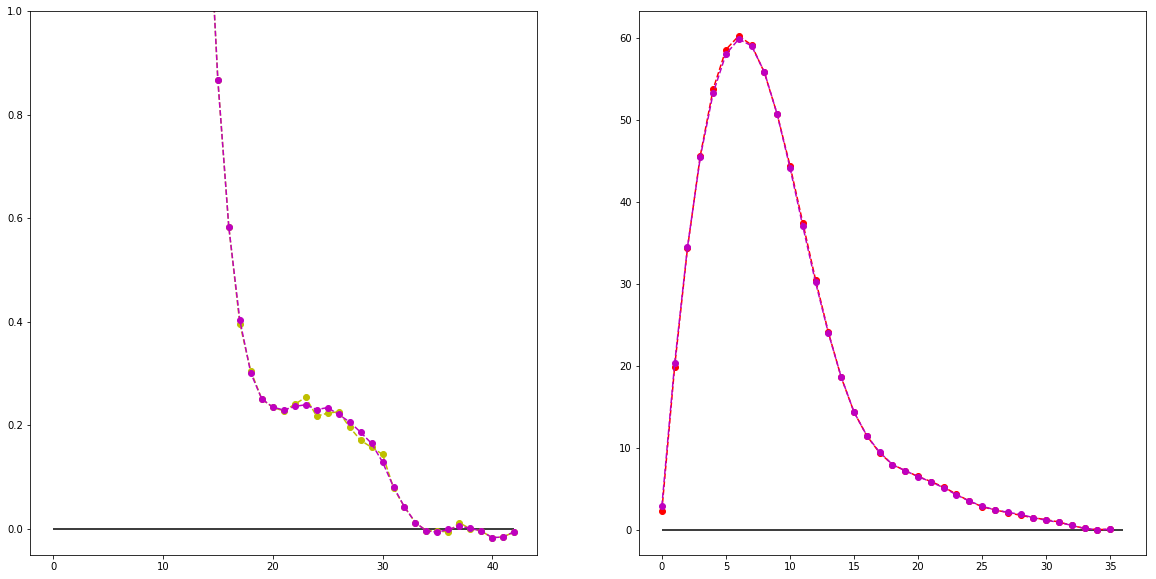

In [47]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
axs[0].plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'yo--')
axs[0].plot(np.array(b_init[1:1+len(pair_knots)])*(6*0.1**3) , 'mo--')

axs[0].set_ylim(-0.05,1.0)
axs[0].hlines(0.0, 0, 42)
axs[1].plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'ro--')
axs[1].plot(np.array(b_init[1+len(pair_knots):])*(6*0.1**3) , 'mo--')
axs[1].hlines(0.0, 0, 36)

10
[slice(0, 200, 1), slice(200, 346, 1), slice(346, 582, 1), slice(582, 715, 1), slice(715, 851, 1), slice(851, 1050, 1), slice(1050, 1141, 1), slice(1141, 1263, 1), slice(1263, 1269, 1), slice(0, 1469, 1)]
[-1139.193, 0.0, -1136.403, -1136.752, -1190.265, -1127.178]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


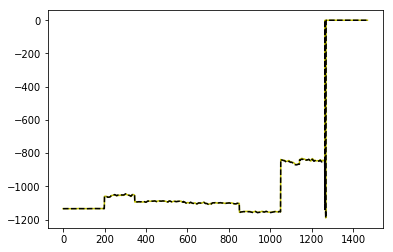

In [48]:
plt.plot(energy(b_all, X), 'y')
plt.plot(y[:,0], 'k--')
print(len(bounds))
print(bounds)
print([round(z, 3) for z in energy(b_all, X)[bounds[-2]]])
print([round(z, 3) for z in y[bounds[-2],0]])

In [49]:
stats_file = 'stats_bs_force_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpfx = pickle.load(fi, encoding='latin1')

stats_bsplinex = tpf_to_bsplines(stats_tpfx)

target_file = 'target_bs_force_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targetsx = pickle.load(fi, encoding='latin1')

len 50


In [50]:
stats_listx = [downselect(stats_bsplinex, pair_knots, edens_knots, bspline=True)]

for key in targets.keys():
    targetsx[key]['weight'] = 1.0
    
for i, stat in enumerate(stats_listx[-1:]):
    Xall, yall, weights, beta, dl, bounds, force_atoms = make_input_matrices_forces(targetsx, stat, keytrj=tkeys, combined=0.35, dl_dict=dl_dict)
    
    #Xall, yall, weights, beta, bounds = make_input_matrices(targetsx, stat, keytrj=tkeys)
    

lens forces 200 200 200 200
lens forces 146 146 146 146
lens forces 126 126 126 126
lens forces 236 236 236 236
lens forces 133 133 133 133
lens forces 136 136 136 136
lens forces 199 199 199 199
lens forces 91 91 91 91
lens forces 122 122 122 122
lens forces 21 21 21 21
lens forces 8 8 8 8
lens forces 8 8 8 8
lens forces 10 10 10 10
lens forces 12 12 12 12
lens forces 6 6 6 6
bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1410, 1), slice(1410, 1418, 1), slice(1418, 1426, 1), slice(1426, 1436, 1), slice(1436, 1448, 1), slice(1448, 1454, 1), slice(0, 1654, 1)]


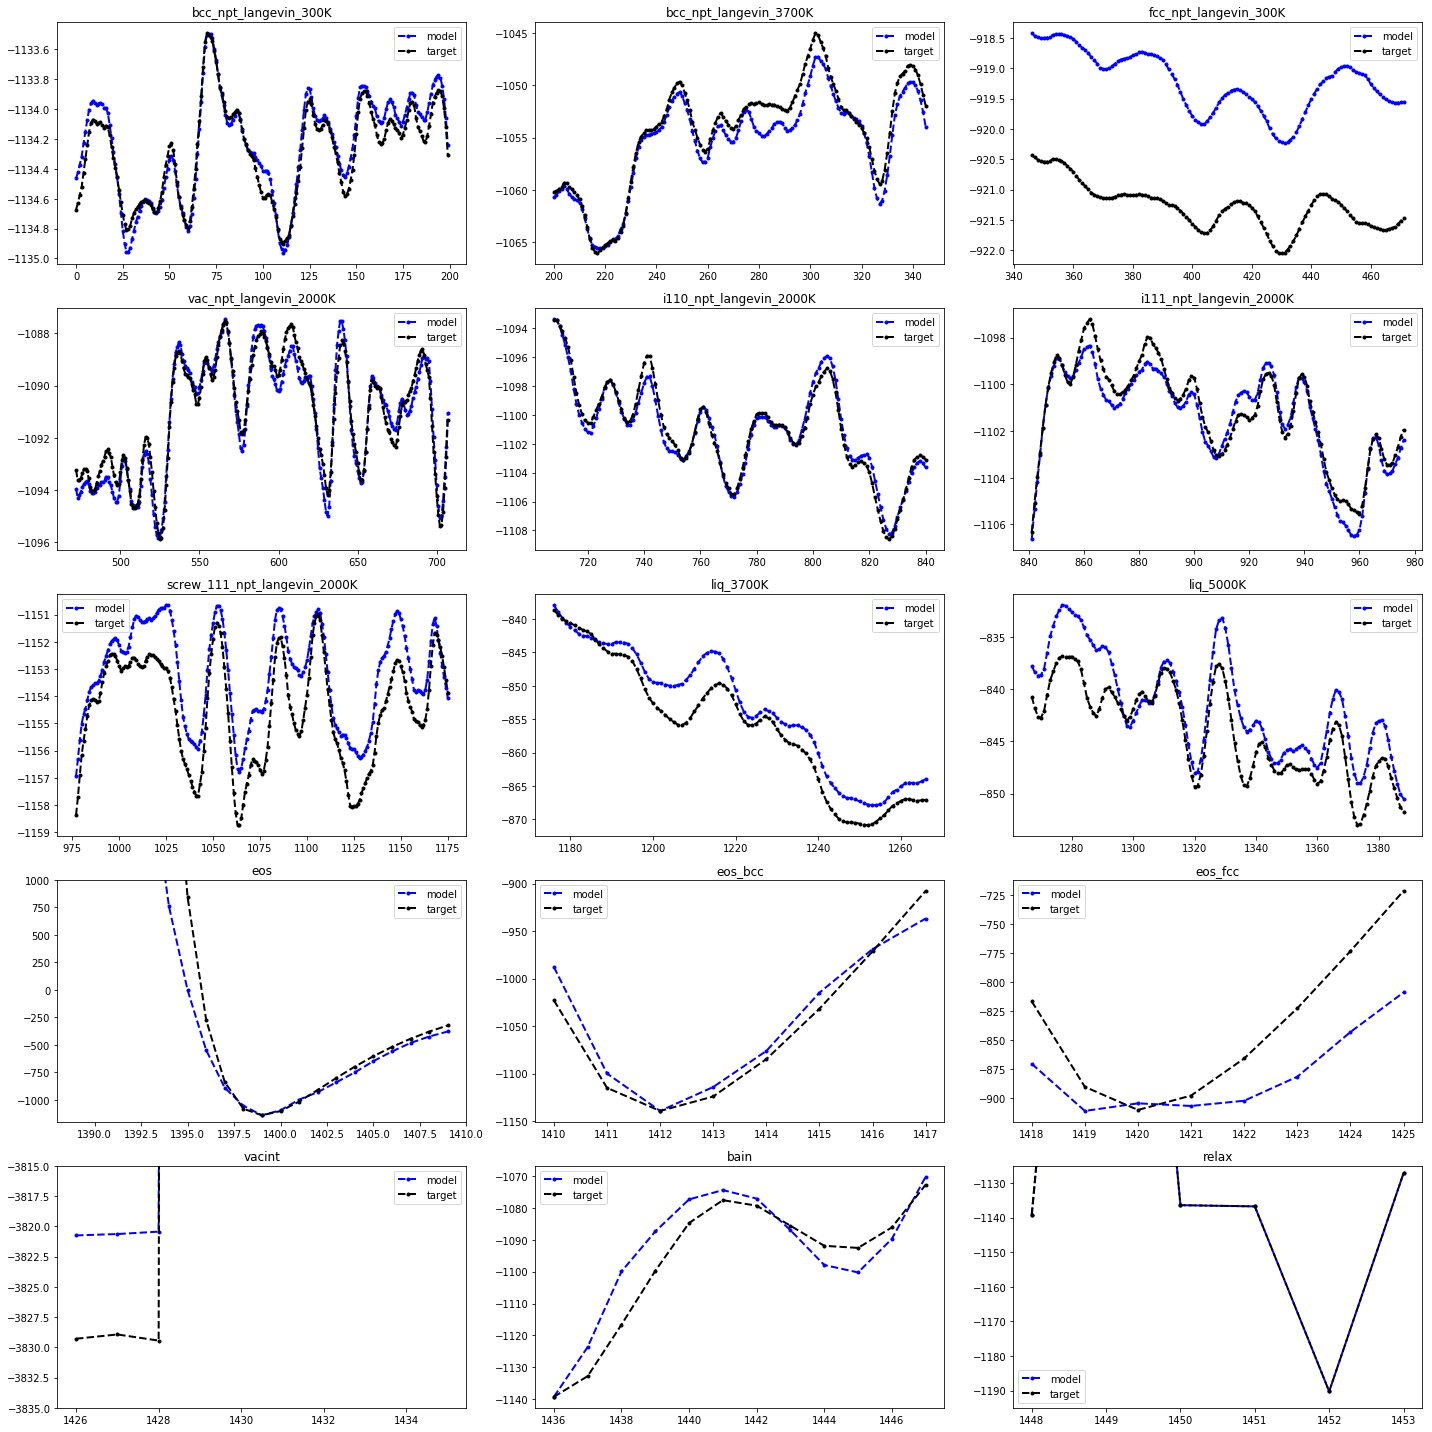

In [51]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
    rr = list(range(len(Xall[0])))[bounds[k]][:]

    axes[i,j].plot(rr, energy(b_all, Xall)[bounds[k]][:], 'b.--', lw=2, label='model')

    axes[i,j].plot(rr, yall[bounds[k],0][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3815)
#        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [115]:
p_knots = np.array(pair_knots)+0.4
print(p_knots)
e_knots = np.array(edens_knots)+0.4
print(e_knots)
n_edens = len(e_knots)

[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95 5.05 5.15 5.25 5.35 5.45 5.55
 5.65]
[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95]


In [116]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [117]:
M = _bspline_coeffs_to_tpf(41)

In [118]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[1:-n_edens]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.70417226e+03  4.13423815e+03  3.60397825e+03  3.11346024e+03
  2.66302750e+03  2.25258846e+03  1.88082365e+03  1.54697937e+03
  1.25083317e+03  9.92104104e+02  7.70968996e+02  5.86895530e+02
  4.33960550e+02  3.08127025e+02  2.13279363e+02  1.44599321e+02
  9.70922418e+01  6.66420162e+01  5.01808655e+01  4.18434145e+01
  3.92814989e+01  3.88058201e+01  3.90736696e+01  3.90564985e+01
  3.80019954e+01  3.69774317e+01  3.49288610e+01  3.44176478e+01
  3.07358626e+01  2.65367220e+01  2.09352894e+01  1.35480479e+01
  7.03962431e+00  2.02979256e+00 -6.91721500e-01 -1.11666412e+00
 -1.60434154e-01  7.61189585e-01  2.27605036e-01 -6.94012140e-01
 -2.81527516e+00 -2.56153955e+00 -8.43675194e-01]


ValueError: shapes (45,41) and (43,) not aligned: 41 (dim 1) != 43 (dim 0)

In [ ]:
Medens = _bspline_coeffs_to_tpf(35)

In [ ]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
ed11_ext = np.array(list(b_all[-n_edens:]))#*(6*0.1**3)
print(ed11_ext)
edens_coeff = Medens.dot(ed11_ext)
print(edens_coeff)

In [ ]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
print(len(tpf_coeff), len(p_knot))
e_knot = [1.05, 1.15, 1.25, 1.35] + list(e_knots)
print(len(edens_coeff), len(e_knot))

In [ ]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-0.3,1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [ ]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[-n_edens:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[-n_edens:], e_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, edens_coeff, e_knot) for r in rr], 'r--')
plt.ylim(-10,50)
plt.xlim(4,5)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [ ]:
tpf_coeff

In [ ]:
edens_coeff

In [ ]:
params = {
    'hyperparams':{'pair':[], 'edens':[]},
    'params':{'pair':[], 'edens':[]}}
params['hyperparams']['pair'] = p_knot
params['params']['pair'] = tpf_coeff
params['hyperparams']['edens'] = e_knot
params['params']['edens'] = edens_coeff
params['params']['embed'] = [-1.0, b_all[0]]

In [ ]:
param_list = [params]
#param_list

In [ ]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

for params in param_list[-1:]:
    params_to_pickle(params, file_name)#, encoding='latin1', protocol=3)

In [ ]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)
#params_store[-1]

In [ ]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))

print('edens') 
for c, k in zip(edens_coeff, e_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
        
print('embed')
print(-1.0, b_all[0])
#print(-4.42166597e-01,  1.12818607e-04)
#print(-4.49779872e-01,  1.09664665e-04)

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']